# Agglomerative Clustering SciPy Demo: Mixed Data

* [Utility Functions](#scrollTo=yWrLl-O_ng9h&line=1&uniqifier=1)
* [Preprocess Data](#scrollTo=2267a5e4&line=4&uniqifier=1)
* [EDA](#scrollTo=ZCNMfHabwmCN&line=1&uniqifier=1)
* [Feature Transformation](#scrollTo=9shZUfxWw0bD&line=1&uniqifier=1)
* [Gower Distance Matrix](#scrollTo=db375075&line=1&uniqifier=1)
* [UMAP Visualization](#scrollTo=5uml_AJit5Gf&line=1&uniqifier=1)
* [Linkage Matrix](#scrollTo=b2jQogenuBp_&line=1&uniqifier=1)
* [Dendrogram Plots](#scrollTo=qwo5qijlxykY&line=1&uniqifier=1)
* [Inconsistency Matrix & Plots](#scrollTo=12U5GjzqsvTe&line=1&uniqifier=1)
* [Cluster & Feature Analysis](#scrollTo=GGDv0M_NttiW&line=1&uniqifier=1)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, inconsistent
from scipy.spatial.distance import squareform

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

# from ch_9_funcs import plot_cluster_dendrogram, plot_silouethes_agglomer, cophenetic_corr
# from ch_9_consts import CAR_85_COLUMN_DESCRIPTION

random.seed(1)
sns.set_theme()

In [ ]:
# Remove all umap-related packages
!pip uninstall umap umap-learn -y

# Clear any cached modules
import sys
modules_to_remove = [key for key in sys.modules.keys() if 'umap' in key]
for module in modules_to_remove:
    del sys.modules[module]

# Reinstall umap-learn
!pip install umap-learn

# Now try importing with the full path
import umap.umap_ as umap
# import umap.plot as umap_plot

Found existing installation: umap-learn 0.5.9.post2
Uninstalling umap-learn-0.5.9.post2:
  Successfully uninstalled umap-learn-0.5.9.post2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
!pip install gower

In [ ]:
import gower

# Utility Functions

In [ ]:
import numpy as np

from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist, squareform

from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm


def cophenetic_corr(linkage_matrix, data_mtx, distance_measure='euclidean'):

    """
    Calculates cophenetic correlation.

    :param linkage_matrix: Linkage matrix.
    :param data_mtx: Data if distce measure is not "precomputed", pairwise distances otherwise.
    :param distance_measure: Distance mesure name.
    """

    if distance_measure != 'precomputed':

        cop_corr = cophenet(
            linkage_matrix,
            pdist(data_mtx, metric=distance_measure),
        )[0]

    else:

        cop_corr = cophenet(
            linkage_matrix,
            squareform(data_mtx),
        )[0]

    print(
        'Cophenetic correlation : {}'.format(cop_corr)
    )



def plot_cluster_dendrogram(
    clusters, linkage_matrix, dataset_df, orientation='left',
    legend_position='upper left', leaf_font_size=None, title=None, labels=None):
    """
    Plots dendrogram where links are colored based on clusters.

    :param clusters: Cluster id for each data point.
    :param linkage_matrix: Linkage matrix.
    :param dataset_df: Dataset dataframe.
    :param orientation: Dendrogram orrientation
    :param legend_position: Legend position, e.g. 'upper left'
    :param leaf_font_size: Leaf font size.
    :param title: Plot title.
    :param labels: Custom leaf labels.
    :return: Collor pallete used to color each cluster.
    """

    # Get unique clusters
    unique_clusters = np.unique(clusters)
    # Get first two columns of linkage matrix (representing nodes in links)
    trunc_linkage = linkage_matrix[:, :2].astype(np.int32)
    # Get last "original" point ID
    max_orig_point_id = dataset_df.shape[0]

    # Initialize dict that will hold
    # cluster-link relations
    cluster_link_dict = {}

    # Iterate through all the clusters
    for clust in unique_clusters:

        # Get all points belonging to current cluster
        clust_points = np.where(clusters==clust)[0]

        # Perform itteration untill we collect all links associated
        # with current cluster
        while True:

            # Find all positions in linkage matrix where points from
            # cluster are present. This positions in linkage matrix also
            # denote IDs of merged nodes (merged node id = position in linkage mtx + max_orig_point_id)
            points_present = np.isin(trunc_linkage, clust_points)

            # Sum the matrix in order to find positions where
            # both points belong to current cluster
            present_points_sum = np.sum(points_present,axis=1)
            loc_of_twos = np.where(present_points_sum==2)[0]

            # Get link locations
            links_to_add = list(loc_of_twos)

            # Variable that will be changed to True
            # if new links are added to the dict
            added_new = False

            # Iterate through the link
            for link in links_to_add:

                # Get true ids of the links
                link_aug = link + max_orig_point_id

                # Add new links
                if link_aug not in cluster_link_dict:
                    added_new=True
                    cluster_link_dict[link_aug] = clust

            # If no new links are added this means that all
            # links associated with current cluster are already
            # added.
            # In this case break current loop and proceed to the next cluster.
            if not added_new:
                break

            # Add merged links for next itteration
            new_clust_points = loc_of_twos + max_orig_point_id
            clust_points = np.concatenate([clust_points, new_clust_points])

    # Get collor pallete having one color per cluster
    colors = plt.cm.rainbow(np.linspace(0, 1, len(set(clusters))))

    # Transform colors to hex format (dedrogram function requires it)
    colors_hex = [matplotlib.colors.rgb2hex(c) for c in colors]
    color_dict = {key: colors_hex[cluster_link_dict[key]-1] for key in cluster_link_dict}
    link_color_func = lambda x: color_dict[x] if x in color_dict else 'black'

    # Prepare legend
    patches = [
        mpatches.Patch(color=colors_hex[i], label=str(unique_clusters[i]))
        for i in range(len(colors_hex))
    ]

    if labels is None:
        labels = dataset_df.index

    # Plot the dendrogram
    dendrogram(
        linkage_matrix,
        link_color_func=link_color_func,
        orientation=orientation,
        labels=labels,
        leaf_font_size=leaf_font_size
    )

    # Plot the legend
    plt.legend(handles=patches, loc=legend_position)
    plt.title(title)

    # Show the dendrogram
    plt.show()

    return colors_hex


def plot_silouethes_agglomer(
    data_df, clusters, dendr_colors=None, embedding_mtx=None,
    figsize=(12,5), distance_measure='euclidean'):
    """
    Plot silouethe scores and a given embedding.

    :param data_df: Dataset dataframe.
    :param clusters: Cluster ids.
    :param dendr_colors: Dendrogram colors or other color pallete.
    :param embedding_mtx: Embedding matrix that will be used for plotting the scatterplot.
    :param figsize: Figure size.
    :param distance_measure: Distance measure.
    :return: Overall silhouette score.
    """

    y_lower = 10

    # Calculate average silhouette score
    silhouette_scr = silhouette_score(data_df, clusters, metric=distance_measure)

    # Calculate silhouette score for each data point
    sample_silhouette_values = silhouette_samples(data_df, clusters, metric=distance_measure)

    # Plot clustering and silouethes
    if embedding_mtx is not None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    else:
        fig, ax1 = plt.subplots(1, 1, figsize=figsize)

    num_clust = np.unique(clusters).shape[0]

    # Adjust for case when clusters start at 1
    if 0 in clusters:
        adjust_factor = 0
    else:
        adjust_factor = 1

    # Plot siluethe scores for points belonging to each cluster
    for clust_i in range(num_clust):

        # Get points bellogning to the current cluster
        ith_cluster_silhouette_values = sample_silhouette_values[
            clusters == clust_i + adjust_factor
        ]

        # Sort points by silhouette value
        ith_cluster_silhouette_values.sort()

        # Get size of current cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]

        # Get upper value of y cooridnate for current cluster
        y_upper = y_lower + size_cluster_i

        # Fill values between y_lower and y_upper with silhouette score values
        # for data points

        if dendr_colors:
            color = dendr_colors[clust_i]
        else:
            color = cm.nipy_spectral(float(clust_i) / num_clust)

        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(clust_i + adjust_factor))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10

    # Set title and labels silhouette subplot
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_scr, color="red", linestyle="--")

    # Clear the yaxis labels / ticks
    ax1.set_yticks([])
    # Set x-ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Map cluster labels to cluster colors
    if dendr_colors:
        colors = [dendr_colors[clust_i-adjust_factor] for clust_i in clusters]
    else:
        colors = [cm.nipy_spectral(float(clust_i-adjust_factor) / num_clust) for clust_i in clusters]

    if embedding_mtx is not None:

        # 2nd Plot showing the actual clusters formed
        ax2.scatter(
            embedding_mtx[:, 0],
            embedding_mtx[:, 1],
            marker=".", s=30, lw=0,
            alpha=0.7, c=colors,
            edgecolor="k"
        )

        # Set title and labels for scatterplot
        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("dim1")
        ax2.set_ylabel("dim2")

    # Add main title
    plt.suptitle(
        "Silhouette analysis for KMeans clustering",
        fontsize=14,
        fontweight="bold",
    )

    # Show the plot
    plt.show()

    return silhouette_scr

# Load and preprocess

The 1985 Automobile Dataset is a comprehensive collection of data that captures various specifications and details about automobiles from that year. It typically includes various characteristics of the cars. Dataset contains following columns:

Citation : Schlimmer,Jeffrey. (1987). Automobile. UCI Machine Learning Repository. https://doi.org/10.24432/C5B01C.

In [ ]:
CAR_85_COLUMN_DESCRIPTION = {
    'symboling': 'Insurance risk rating of the vehicle, ranging from -3 (safest) to 3 (riskiest)',
    'make': 'Brand or manufacturer of the car',
    'fuel-type': 'Type of fuel the car uses, such as diesel or gasoline',
    'aspiration': 'Method of air intake for the engine, either standard or turbocharged',
    'num-of-doors': 'Number of doors the car has',
    'body-style': 'Design form of the car body, like sedan, hatchback, etc.',
    'drive-wheels': 'Type of drivetrain, indicating which wheels are powered (front, rear, or all)',
    'engine-location': 'Position of the engine in the car, either front or rear',
    'wheel-base': 'Distance between the front and rear wheels, measured in inches',
    'length': 'Overall length of the car, measured in inches',
    'width': 'Overall width of the car, measured in inches',
    'height': 'Overall height of the car, measured in inches',
    'curb-weight': 'Weight of the car without any passengers or cargo, measured in pounds',
    'engine-type': 'Configuration and design of the engine (e.g., OHC, OHCV)',
    'num-of-cylinders': 'Total number of cylinders in the engine',
    'engine-size': 'Displacement volume of the engine, measured in cubic centimeters',
    'fuel-system': 'Mechanism or system for delivering fuel to the engine (e.g., MPFI, 2bbl)',
    'bore': 'Internal diameter of each cylinder in the engine, measured in inches',
    'stroke': 'Travel distance of the piston within the engine cylinder, measured in inches',
    'compression-ratio': 'Volume ratio between piston positions at the bottom and top of its stroke',
    'horsepower': 'Engine power output, measured in horsepower',
    'peak-rpm': 'Engine speed at which maximum power output is achieved, measured in RPM',
    'city-mpg': 'Fuel efficiency during city driving, measured in miles per gallon',
    'highway-mpg': 'Fuel efficiency during highway driving, measured in miles per gallon',
    'price': 'Market price of the car, usually provided in USD',
    'price_bins': 'Categorical representation of car price for easier analysis or visualization'
}

In [ ]:
# Load and preview the dataset
data_path = '/content/drive/MyDrive/Colab/Machine Learning/Clustering & Dimensionality Reduction/Clustering/auto_86_dataset.csv'
data_path = '/data/auto_86_dataset.csv'

car_df = pd.read_csv(data_path)
car_df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,?,audi,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250


In [ ]:
car_df.shape

(204, 26)

In [ ]:
car_df = car_df.replace('?', np.nan)

In [ ]:
# Check data for missing values
car_df.isna().sum(axis=0)

,0
symboling,0
normalized-losses,40
make,0
fuel-type,0
aspiration,0
num-of-doors,2
body-style,0
drive-wheels,0
engine-location,0
wheel-base,0


In [ ]:
car_df = car_df.drop(columns=['normalized-losses'])

In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          204 non-null    int64  
 1   make               204 non-null    object 
 2   fuel-type          204 non-null    object 
 3   aspiration         204 non-null    object 
 4   num-of-doors       202 non-null    object 
 5   body-style         204 non-null    object 
 6   drive-wheels       204 non-null    object 
 7   engine-location    204 non-null    object 
 8   wheel-base         204 non-null    float64
 9   length             204 non-null    float64
 10  width              204 non-null    float64
 11  height             204 non-null    float64
 12  curb-weight        204 non-null    int64  
 13  engine-type        204 non-null    object 
 14  num-of-cylinders   204 non-null    object 
 15  engine-size        204 non-null    int64  
 16  fuel-system        204 non

In [ ]:
pd.set_option('display.max_columns', None)
car_df

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
1,1,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
2,2,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950
3,2,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450
4,2,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,-1,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,2952,ohc,four,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845
200,-1,volvo,gas,turbo,four,sedan,rwd,front,109.1,188.8,68.8,55.5,3049,ohc,four,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045
201,-1,volvo,gas,std,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3012,ohcv,six,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485
202,-1,volvo,diesel,turbo,four,sedan,rwd,front,109.1,188.8,68.9,55.5,3217,ohc,six,145,idi,3.01,3.40,23.0,106,4800,26,27,22470


In [ ]:
categ_cols = ['make', 'fuel-type', 'aspiration', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'fuel-system']

In [ ]:
num_mapper = {
    'one': 1,
    'two': 2,
    'three': 3,
    'four': 4,
    'five': 5,
    'six': 6,
    'seven': 7,
    'eight': 8,
    'nine': 9,
    'ten': 10
}

car_df['num-of-doors'] = car_df['num-of-doors'].map(num_mapper)
car_df['num-of-cylinders'] = car_df['num-of-cylinders'].map(num_mapper)

In [ ]:
num_cols = list(set(car_df.columns) - set(categ_cols))

car_df[num_cols] = car_df[num_cols].astype(float)

In [ ]:
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          204 non-null    float64
 1   make               204 non-null    object 
 2   fuel-type          204 non-null    object 
 3   aspiration         204 non-null    object 
 4   num-of-doors       202 non-null    float64
 5   body-style         204 non-null    object 
 6   drive-wheels       204 non-null    object 
 7   engine-location    204 non-null    object 
 8   wheel-base         204 non-null    float64
 9   length             204 non-null    float64
 10  width              204 non-null    float64
 11  height             204 non-null    float64
 12  curb-weight        204 non-null    float64
 13  engine-type        204 non-null    object 
 14  num-of-cylinders   203 non-null    float64
 15  engine-size        204 non-null    float64
 16  fuel-system        204 non

In [ ]:
# Drop missing values
car_df = car_df.dropna().reset_index(drop=True)

# EDA

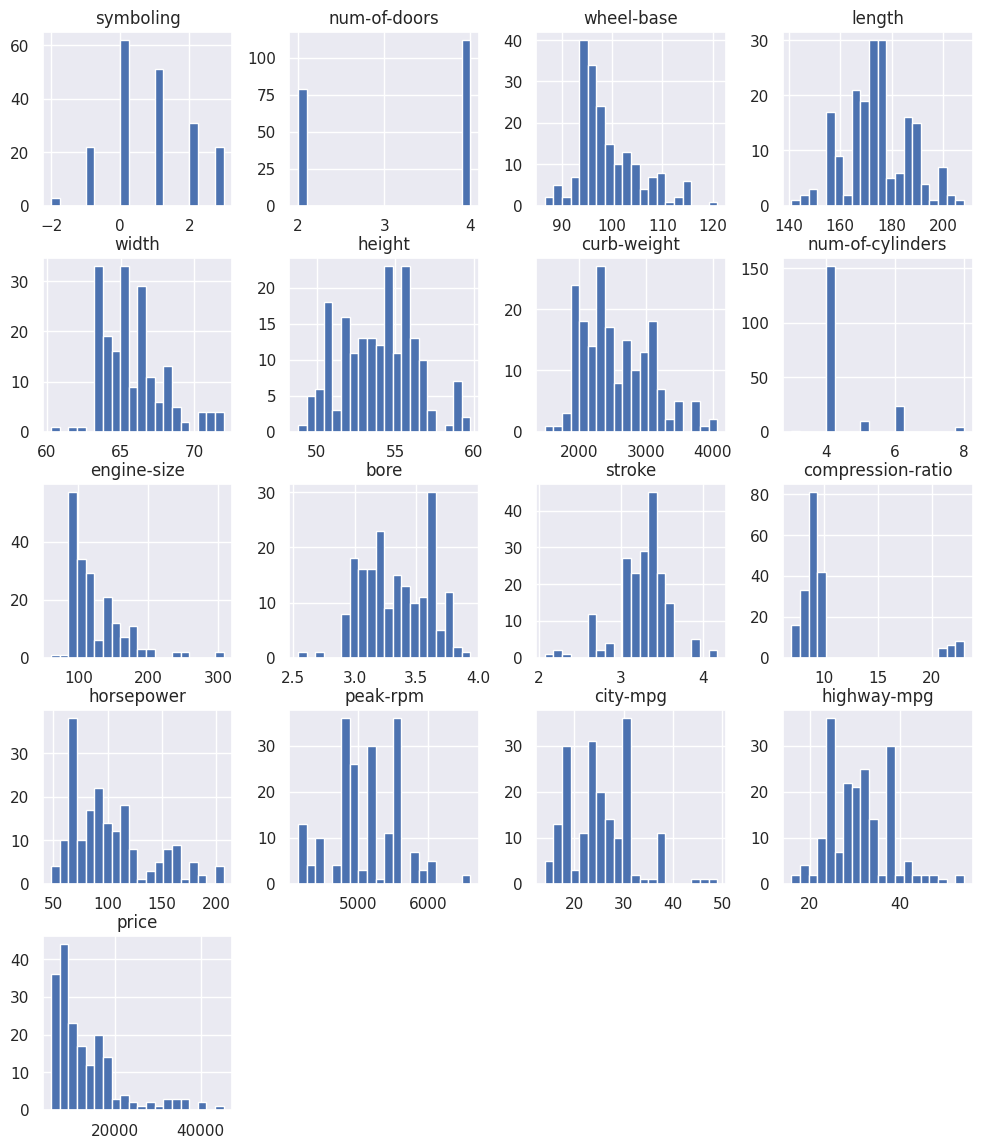

In [ ]:
# Visual inspection of numerical variables
plt.rcParams['figure.figsize'] = [12, 14]
_ = car_df.hist(bins=20)

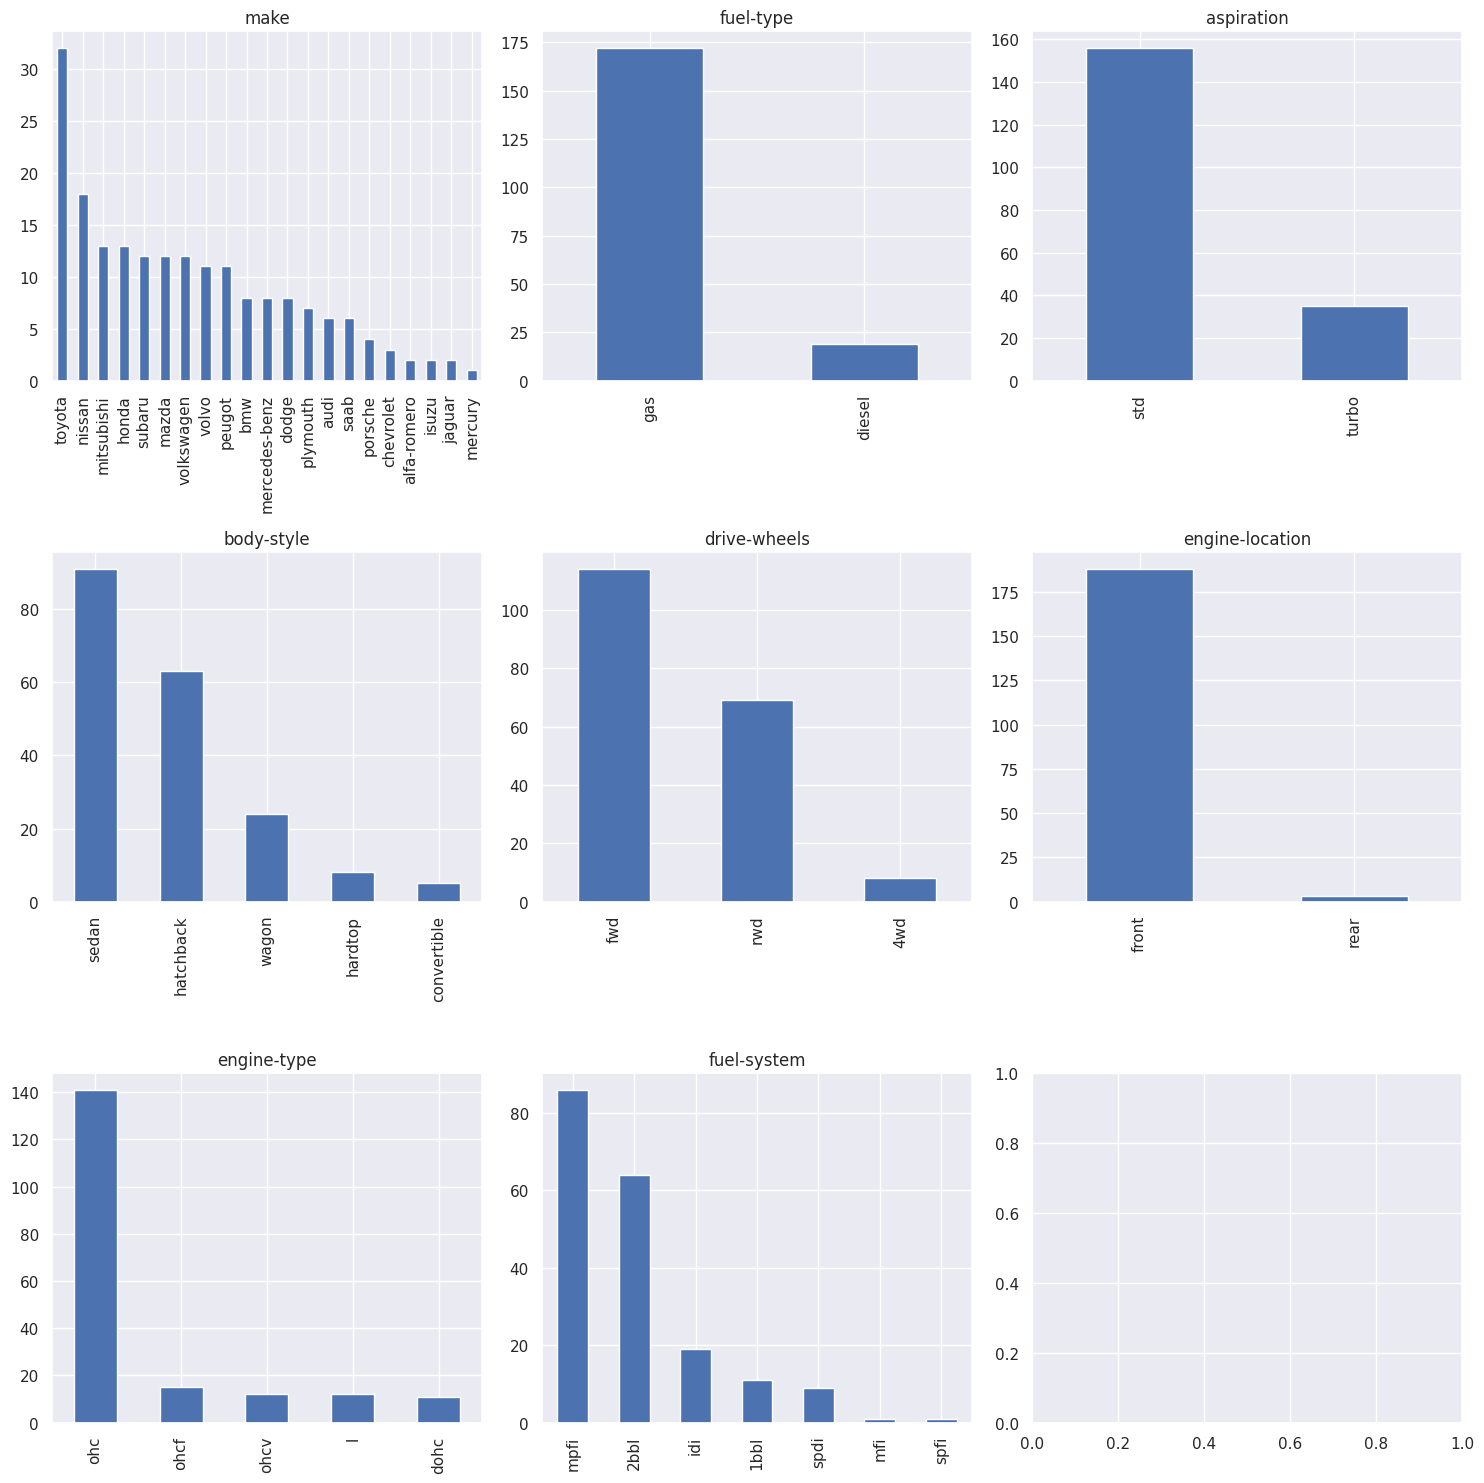

In [ ]:
# Plot categorical columns
num_plots = len(categ_cols)

# Determine number of rows needed for the grid
num_rows = math.ceil(num_plots / 3.0)

# Create subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*5))

# Flatten the axes array if there's more than one row
axs = axs.flatten()

# Plot the data
for i, column in enumerate(categ_cols):
    ax = axs[i]
    car_df[column].value_counts().plot(
        kind='bar',
        ax=ax,
        title=column,
        xlabel=''
    )

plt.tight_layout()

In [ ]:
# Auto-create price bins
bins = np.linspace(car_df['price'].min(), car_df['price'].max(), num=5)
bins

array([ 5118. , 15188.5, 25259. , 35329.5, 45400. ])

In [ ]:
# Customize price bins
custom_bins = [ 5000 , 10000,  15188,  25259 , 35329,  45500]

In [ ]:
# Bin the price so we can easily plot prices
# on the dendrogram
car_sec_info = car_df.copy()
car_sec_info['price_bins'] = pd.cut(car_sec_info['price'], custom_bins, labels=["P1", "P2", "P3", "P4", "P5"])

car_df = car_df.drop(columns='price')

In [ ]:
# Number of cars per price bin
car_sec_info['price_bins'].value_counts()

,count
price_bins,
P1,95
P3,43
P2,37
P4,10
P5,6


# Feature Transformation

In [ ]:
# Get categorical and numerical columns
categ_cols = list(car_df.select_dtypes(include=['object']).columns)
num_cols = list(set(car_df.columns) - set(categ_cols))

categ_bool = [col in categ_cols for col in car_df.columns]

print(categ_cols)
print(num_cols)
print(categ_bool)

['make', 'fuel-type', 'aspiration', 'body-style', 'drive-wheels', 'engine-location', 'engine-type', 'fuel-system']
['engine-size', 'num-of-cylinders', 'compression-ratio', 'peak-rpm', 'symboling', 'horsepower', 'highway-mpg', 'wheel-base', 'bore', 'stroke', 'city-mpg', 'length', 'height', 'width', 'num-of-doors', 'curb-weight']
[False, True, True, True, False, True, True, True, False, False, False, False, False, True, False, False, True, False, False, False, False, False, False, False]


In [ ]:
# Scale numerical columns
scaler = StandardScaler()
car_df[num_cols] = scaler.fit_transform(car_df[num_cols])

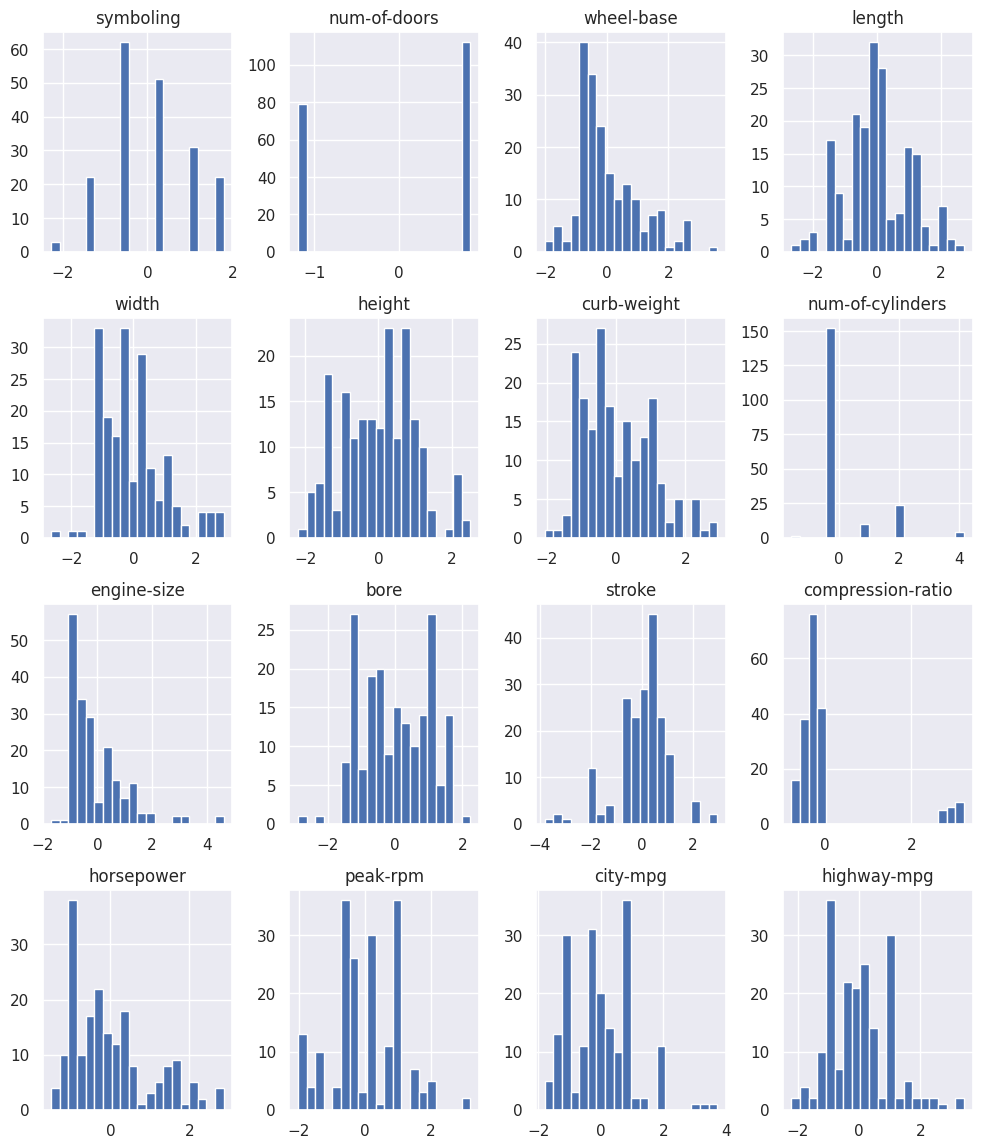

In [ ]:
# Visual inspection of numerical variables
plt.rcParams['figure.figsize'] = [12, 14]
_ = car_df.hist(bins=20)

In [ ]:
# Encode categorical variables
ord_enc = OrdinalEncoder()
car_df[categ_cols] = ord_enc.fit_transform(car_df[categ_cols])

# Perform clustering based on gower distance



In [ ]:
# Calculate distance based on both, numerical and categorical variables
gow_distances = gower.gower_matrix(car_df, cat_features=categ_bool)

print(car_df.shape)
print(gow_distances.shape)

(191, 24)
(191, 191)


In [ ]:
car_sec_info.head()

,symboling,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,price_bins
0,3.0,alfa-romero,gas,std,2.0,convertible,rwd,front,88.6,168.8,64.1,48.8,2548.0,dohc,4.0,130.0,mpfi,3.47,2.68,9.0,111.0,5000.0,21.0,27.0,16500.0,P3
1,1.0,alfa-romero,gas,std,2.0,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823.0,ohcv,6.0,152.0,mpfi,2.68,3.47,9.0,154.0,5000.0,19.0,26.0,16500.0,P3
2,2.0,audi,gas,std,4.0,sedan,fwd,front,99.8,176.6,66.2,54.3,2337.0,ohc,4.0,109.0,mpfi,3.19,3.40,10.0,102.0,5500.0,24.0,30.0,13950.0,P2
3,2.0,audi,gas,std,4.0,sedan,4wd,front,99.4,176.6,66.4,54.3,2824.0,ohc,5.0,136.0,mpfi,3.19,3.40,8.0,115.0,5500.0,18.0,22.0,17450.0,P3
4,2.0,audi,gas,std,2.0,sedan,fwd,front,99.8,177.3,66.3,53.1,2507.0,ohc,5.0,136.0,mpfi,3.19,3.40,8.5,110.0,5500.0,19.0,25.0,15250.0,P3


# UMAP Visualization

In [ ]:
# Perfrom UMAP dimensionality reduction
umap_obj = umap.UMAP(n_neighbors=30, metric='precomputed')
embedding_mtx = umap_obj.fit_transform(gow_distances)

# uplot.points(umap_obj)

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


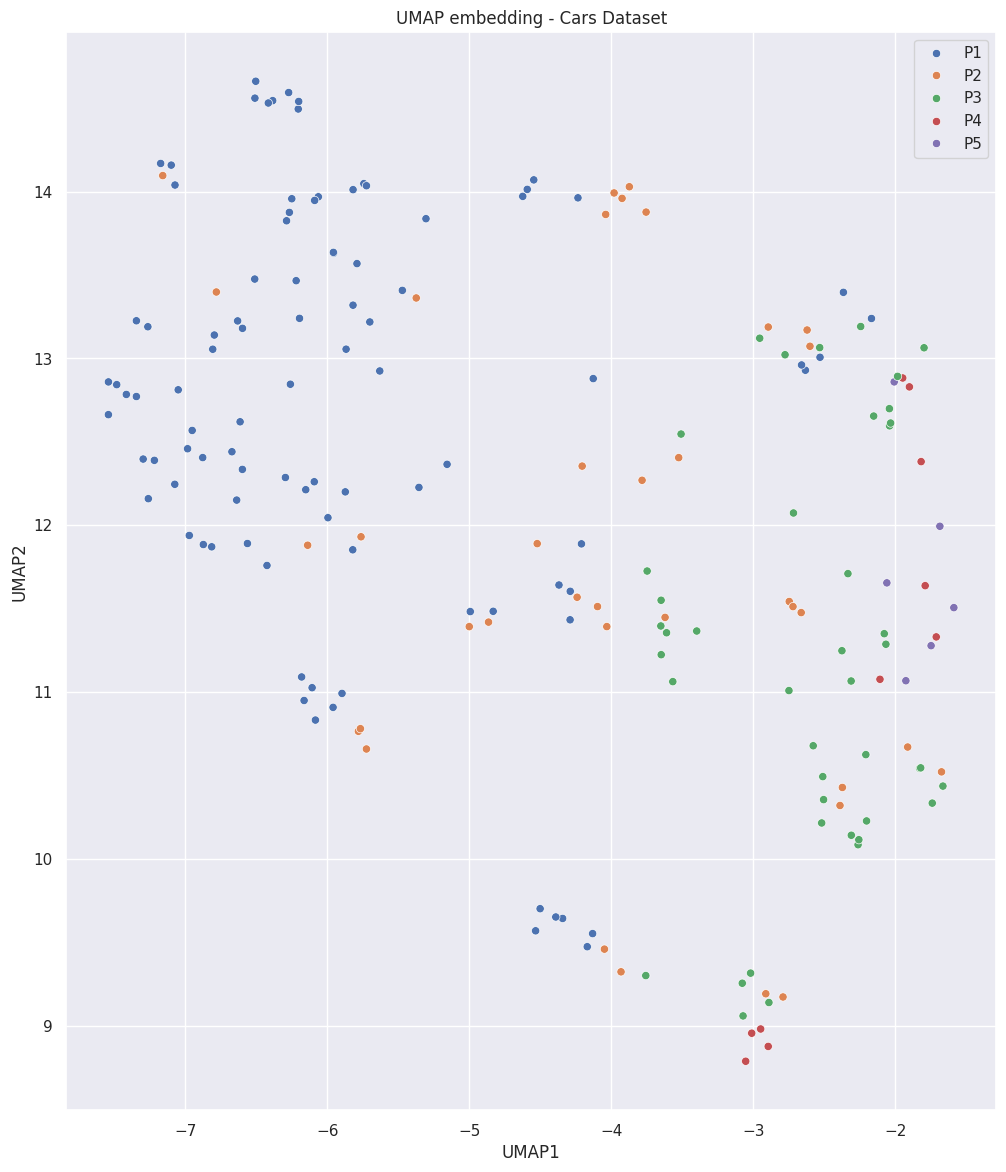

In [ ]:
sns.scatterplot(x=embedding_mtx[:, 0], y=embedding_mtx[:, 1], hue=car_sec_info['price_bins'].values)
plt.title('UMAP embedding - Cars Dataset')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show();

In [ ]:
# umap.plot.connectivity(umap_obj, show_points=True)

In [ ]:
# umap.plot.diagnostic(umap_obj, diagnostic_type='pca')

# Linkage Matrix

In [ ]:
# Create dendrogram based on precomputed distance
gow_distances_condens = squareform(gow_distances)

linkage_matrix = linkage(
    gow_distances_condens,
    method='average'
)

print(gow_distances.shape)
print(gow_distances_condens.shape)
print(linkage_matrix.shape)

(191, 191)
(18145,)
(190, 4)


In [ ]:
# create linkage df
linkage_df = pd.DataFrame(linkage_matrix, columns=['First group', 'Second group', 'Distance', 'Size'])
linkage_df['New id'] = np.arange(linkage_df.shape[0]) + linkage_df.shape[0]+1

linkage_df

,First group,Second group,Distance,Size,New id
0,23.0,24.0,0.000000,2.0,191
1,50.0,52.0,0.000000,2.0,192
2,49.0,51.0,0.000000,2.0,193
3,42.0,43.0,0.000000,2.0,194
4,101.0,105.0,0.000000,2.0,195
...,...,...,...,...,...
185,358.0,359.0,0.317617,19.0,376
186,16.0,374.0,0.327619,115.0,377
187,375.0,377.0,0.335853,169.0,378
188,376.0,378.0,0.402270,188.0,379


In [ ]:
cophenetic_corr(
    linkage_matrix=linkage_matrix,
    data_mtx = gow_distances,
    distance_measure='precomputed'
)

Cophenetic correlation : 0.7371196240909205


# Dendrogram Plots

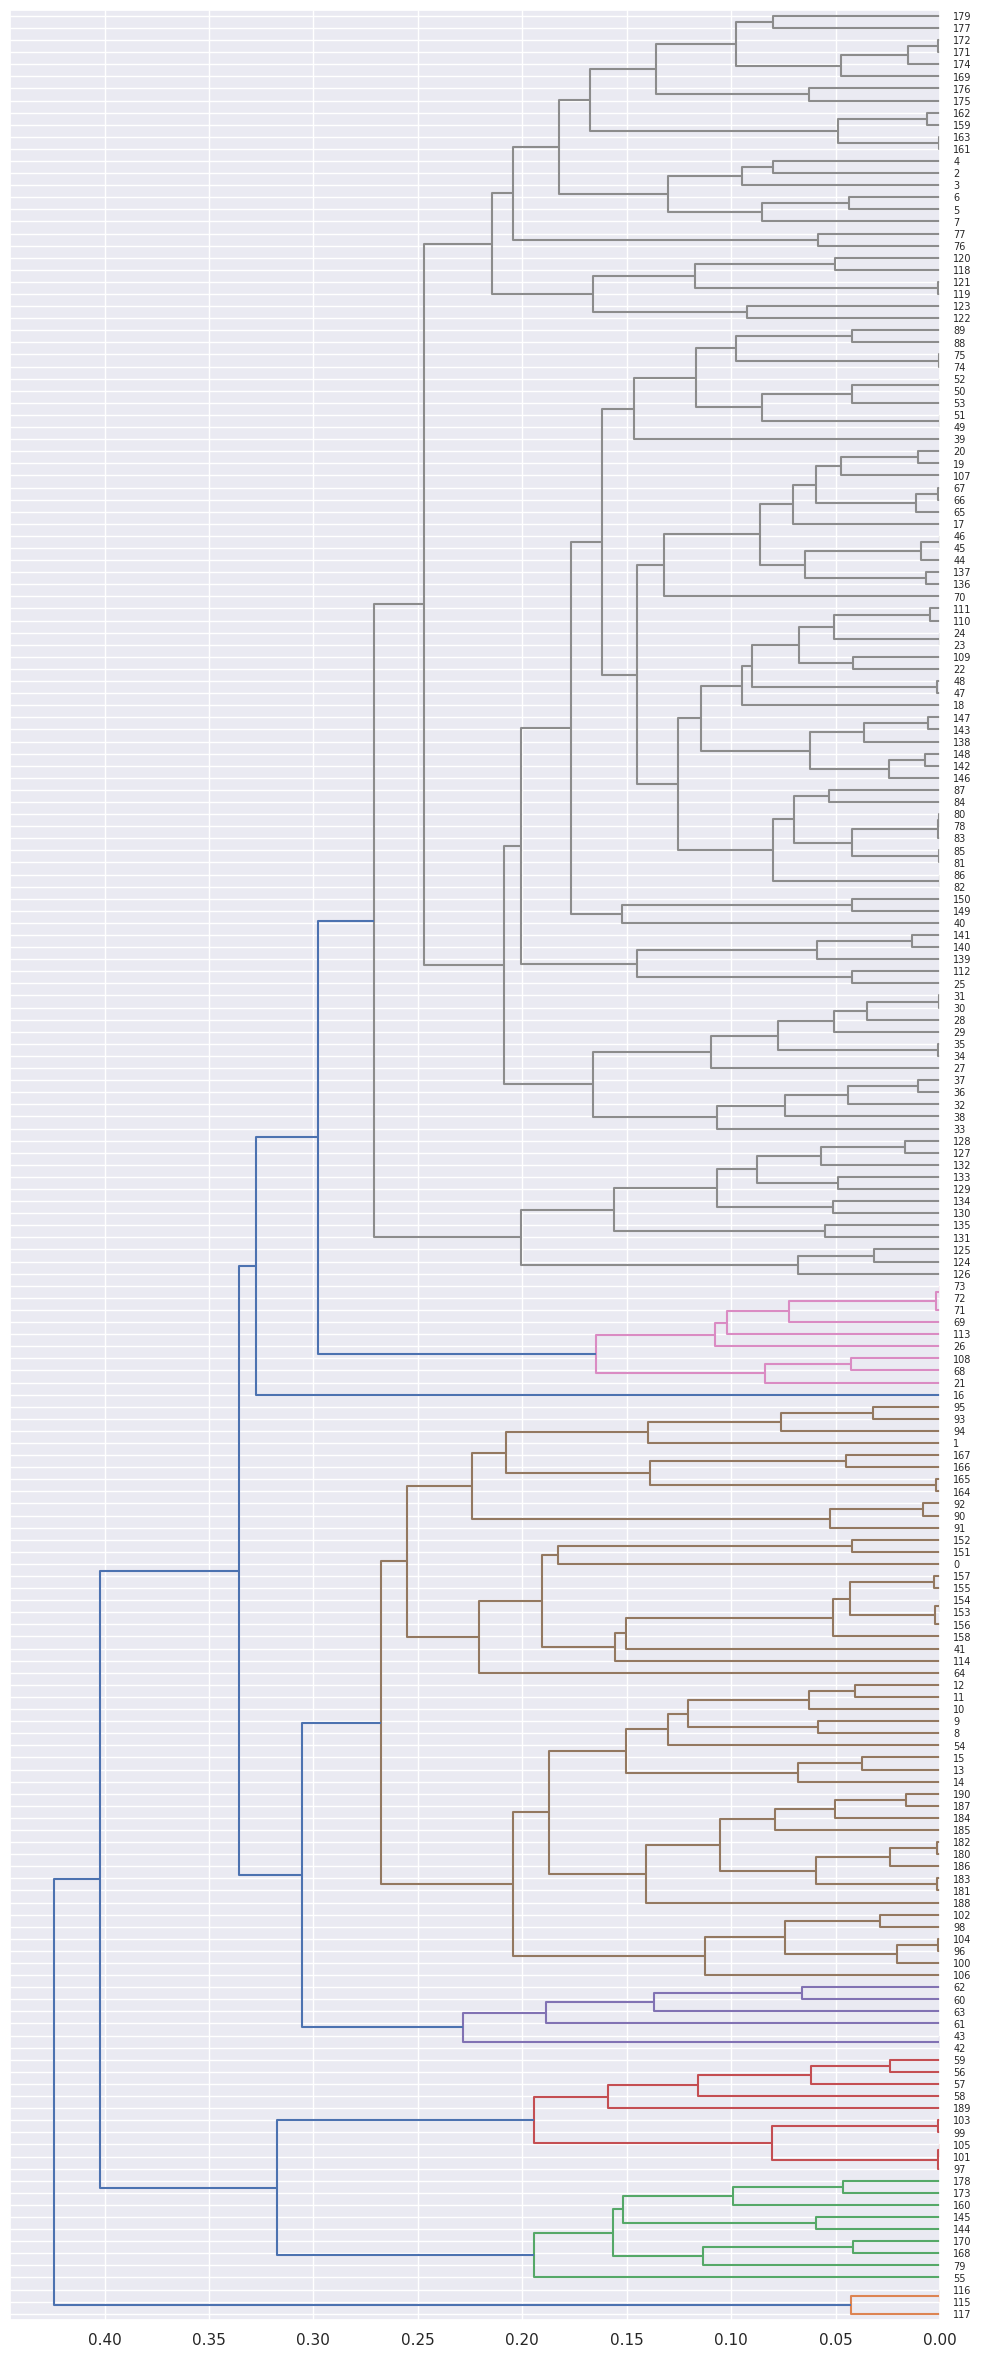

In [ ]:
# Plot the dendrogram
plt.rcParams['figure.figsize'] = [12, 30]
_ = dendrogram(
    linkage_matrix,
    orientation='left',
    labels=car_df.index,
    leaf_font_size=7
)

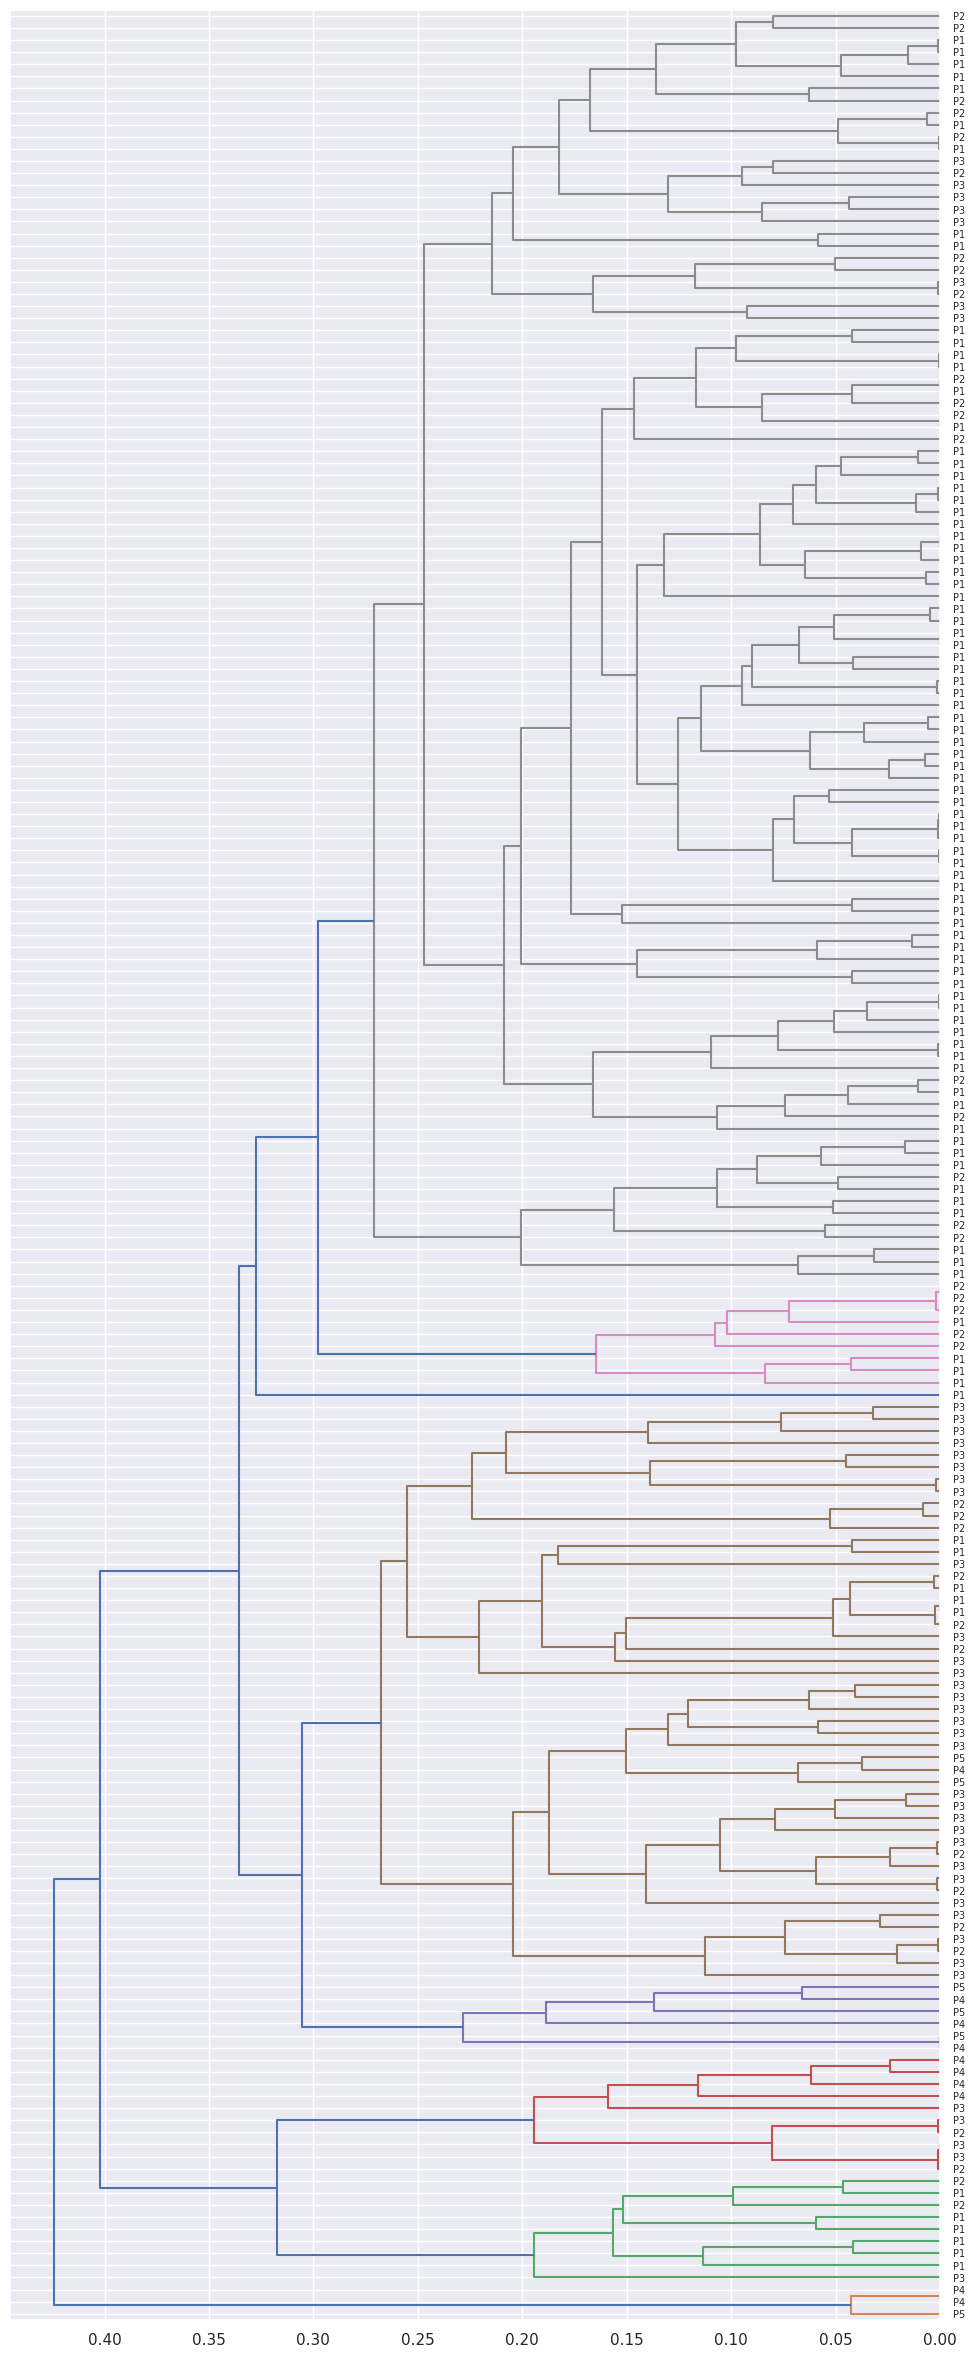

In [ ]:
# Plot the dendrogram
plt.rcParams['figure.figsize'] = [12, 30]
_ = dendrogram(
    linkage_matrix,
    orientation='left',
    labels=car_sec_info['price_bins'].to_numpy(),
    leaf_font_size=7
)

# Inconsistency Method

[[0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [6.46495973e-05 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [8.08119948e-05 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [8.08119948e-05 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [2.10111190e-04 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [2.58598389e-04 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [4.68709593e-04 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [5.33359183e-04 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [6.46495959e-04 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [7.11145578e-04 0.00000000e+00 1.00000000e+00 0.00000000e+00]
 [6.18211780e-04 2.11428019e-04 2.00000000e+00 7.071067

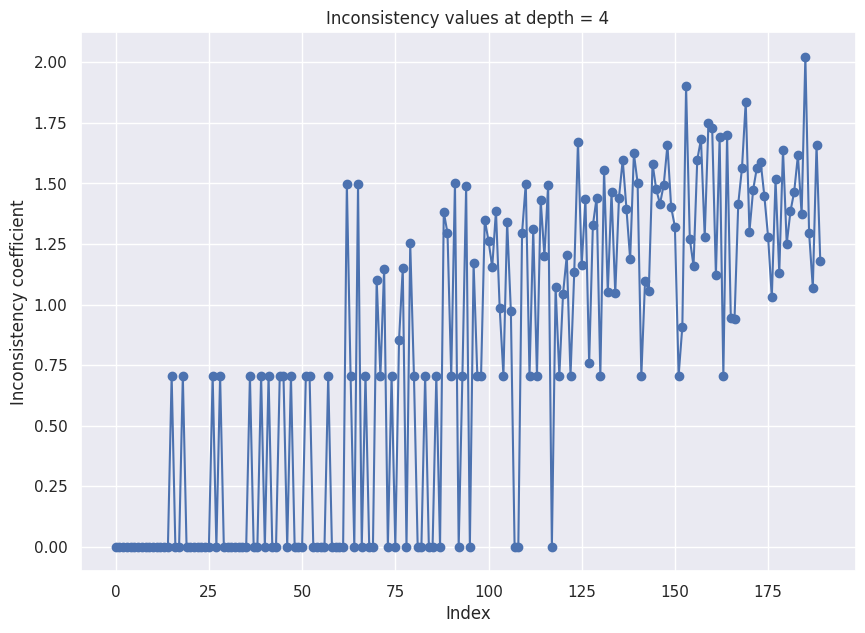

In [ ]:
# Calculate inconsistence matrix
depth=4
incosistent_mtx = inconsistent(linkage_matrix,depth)


print(incosistent_mtx)
# Plot inconsistency scores for given depth
plt.figure(figsize=(10, 7))
plt.plot(incosistent_mtx[:,-1])
plt.scatter(range(incosistent_mtx.shape[0]),incosistent_mtx[:,-1])
plt.title('Inconsistency values at depth = {}'.format(depth))
plt.xlabel('Index')
plt.ylabel('Inconsistency coefficient')
plt.show();

In [ ]:
# Perform clustering based on inconsistency
# and print clusters
clusters = fcluster(Z=linkage_matrix, t=1.6, criterion='inconsistent', R=incosistent_mtx)
print(clusters.shape)
print(clusters)

(191,)
[13 15 31 31 31 31 31 31  9  9  9  9  9  9  9  9 34 26 25 26 26 16 25 25
 25 23 17 22 22 22 22 22 21 21 22 22 21 21 21 28 24 11  4  4 26 26 26 25
 25 28 28 28 28 28  9  2  3  3  3  3  4  4  4  4 14 26 26 26 16 17 27 17
 17 17 28 28 30 30 25  2 25 25 25 25 25 25 25 25 28 28 15 15 15 15 15 15
  5  3  5  3  5  3  5  3  5  3  5 26 16 25 25 25 23 17 12  1  1  1 29 29
 29 29 29 29 18 18 18 20 20 20 20 19 20 20 20 19 26 26 25 23 23 23 25 25
  2  2 25 25 25 24 24 13 13 10 10 10 10 10 10 32  2 32 32 32 15 15 15 15
  2 33  2 33 33  2 33 33 33 33  2 33  6  6  6  6  7  7  6  7  8  3  7]


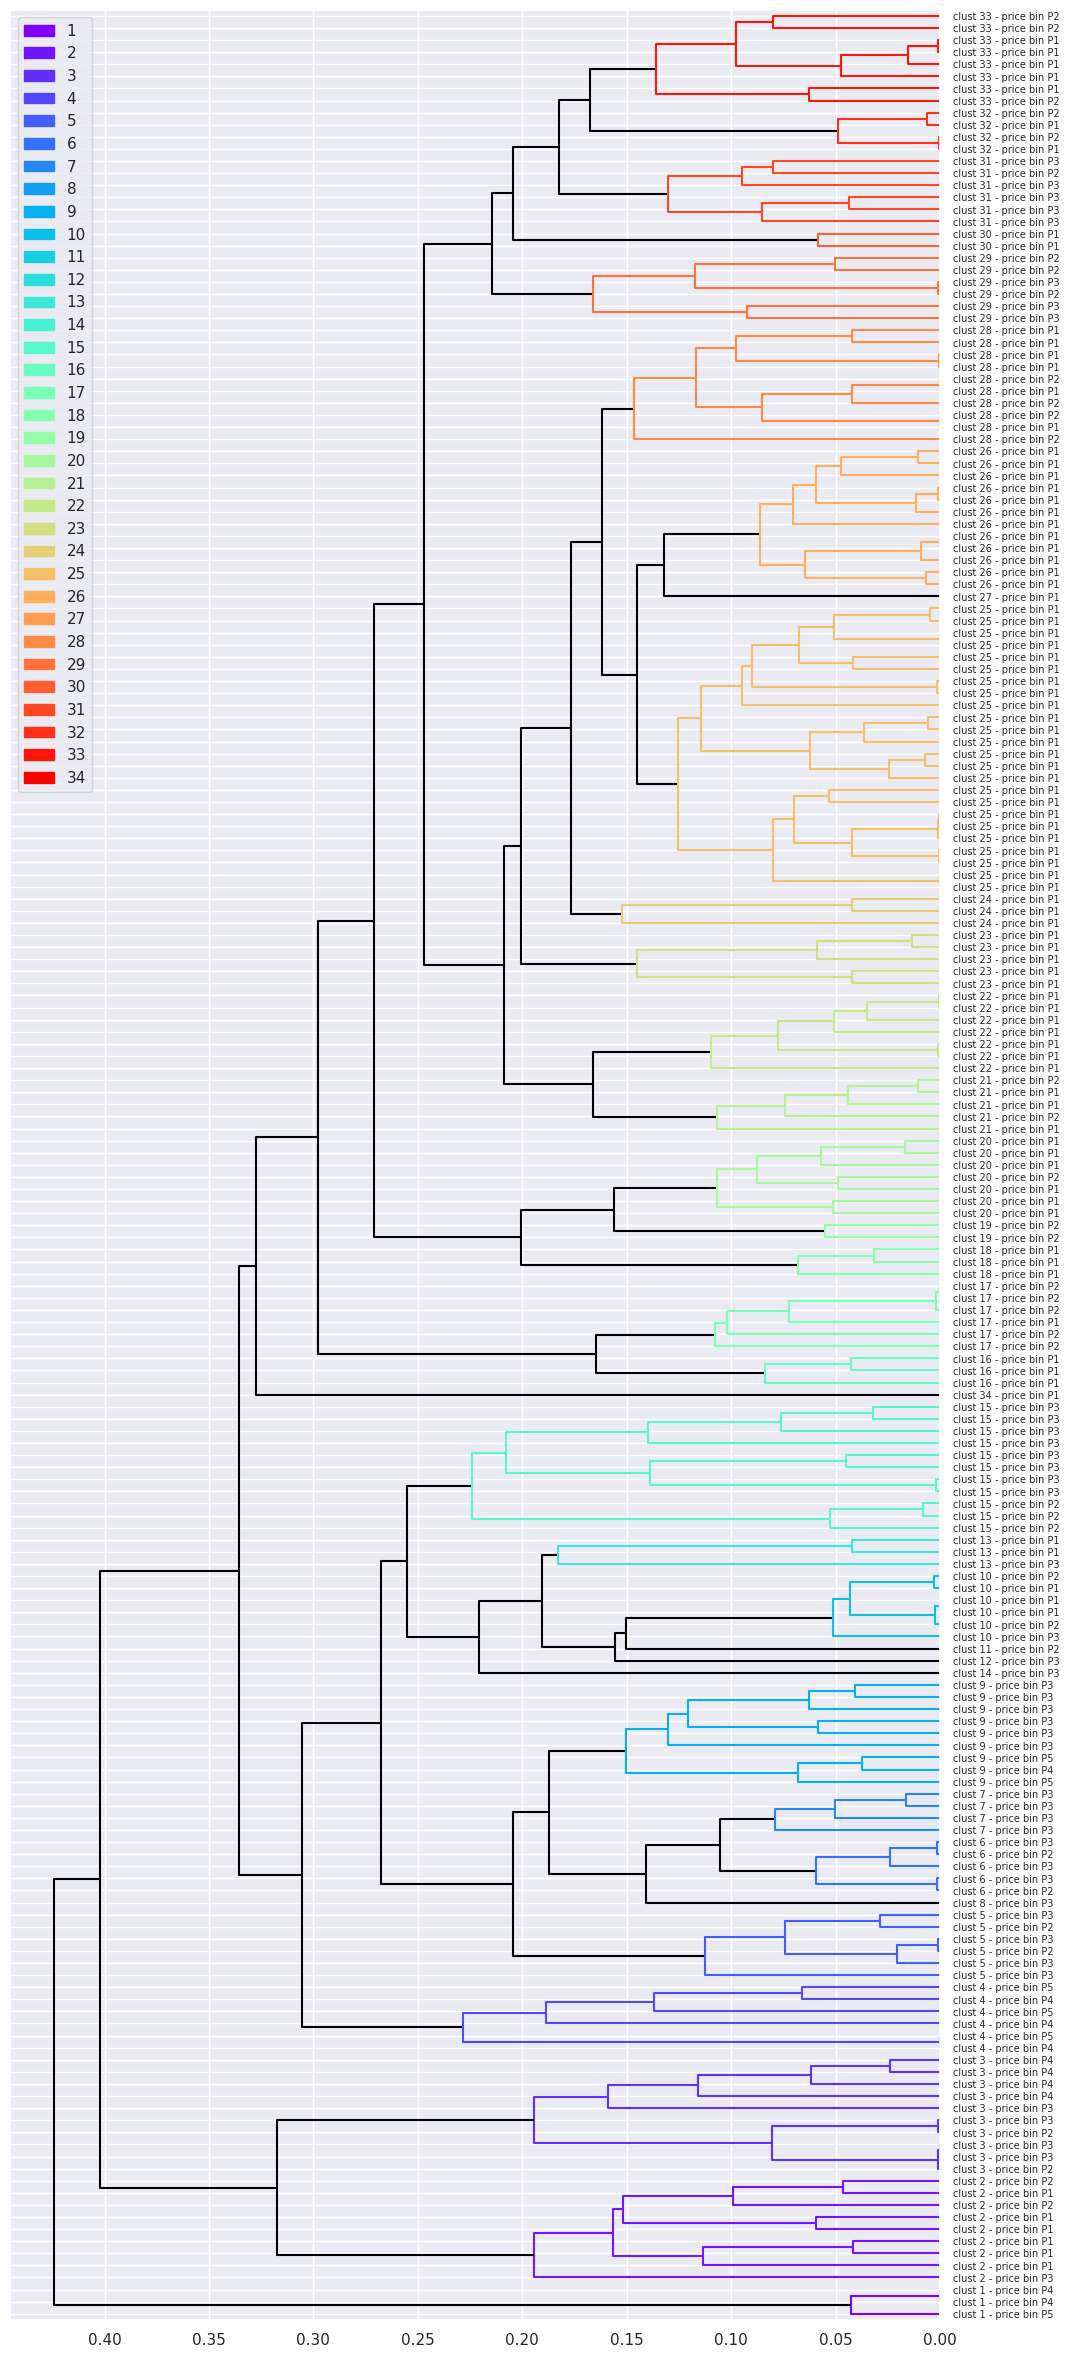

In [ ]:
labels = [
    'clust {} - price bin {}'.format(clust, price)
    for clust, price in zip(clusters, car_sec_info['price_bins'].to_numpy())
]

dendr_colors = plot_cluster_dendrogram(
    linkage_matrix=linkage_matrix,
    dataset_df=car_df,
    clusters=clusters,
    leaf_font_size=7,
    labels=labels
)

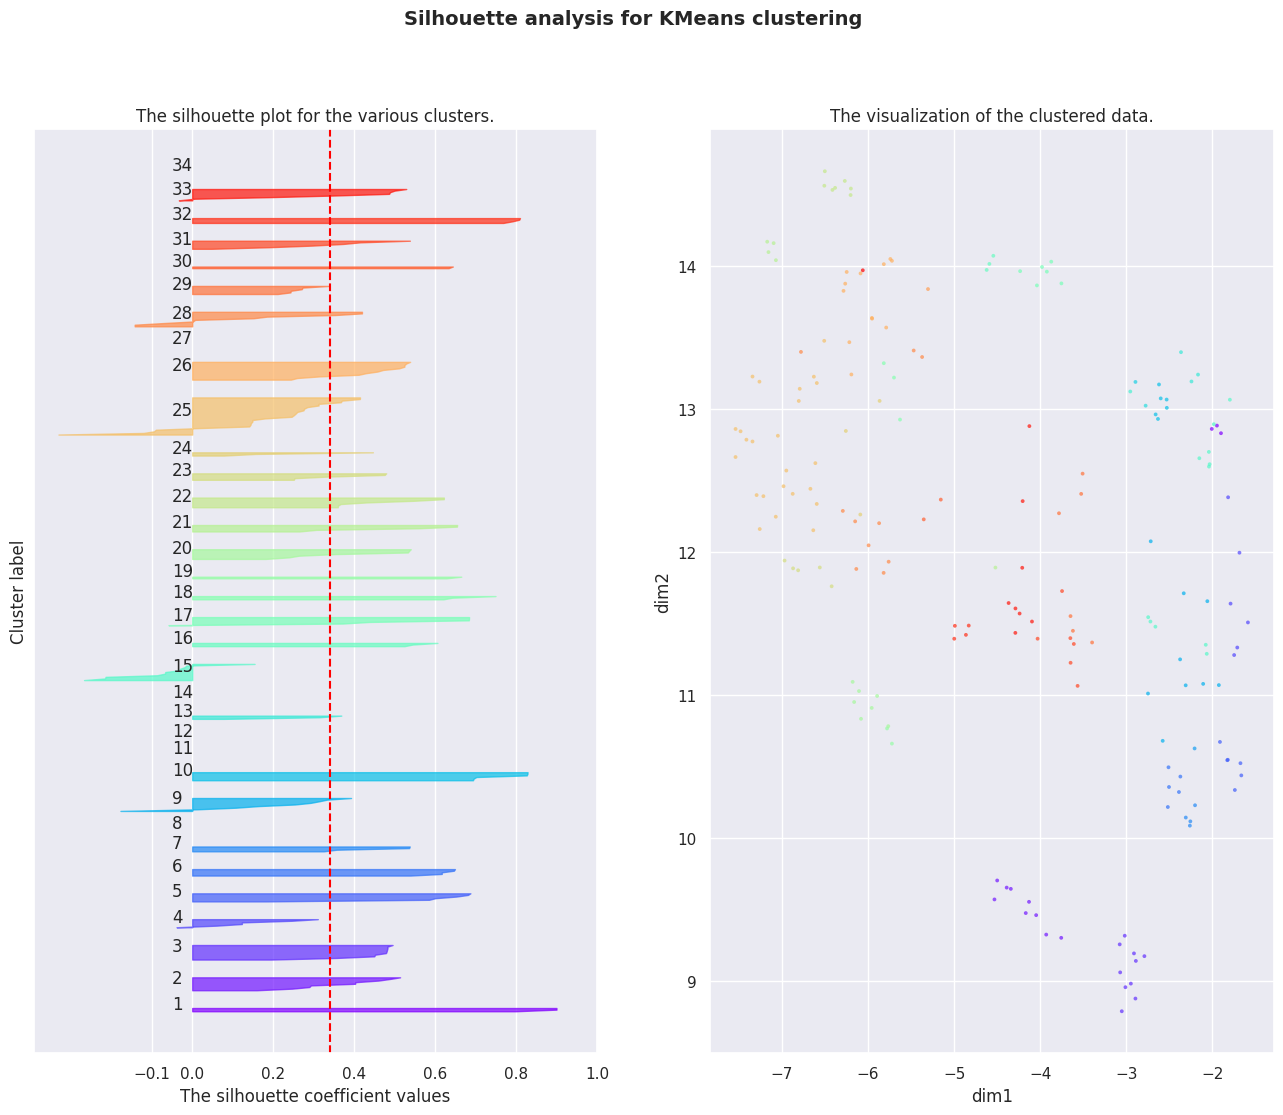

In [ ]:
_ = plot_silouethes_agglomer(
    data_df=gow_distances,
    clusters=clusters,
    dendr_colors=dendr_colors,
    embedding_mtx=embedding_mtx,
    distance_measure='precomputed',
    figsize=(16,12)
)

In [ ]:
car_sec_info['cluster'] = clusters
clust_size = car_sec_info['cluster'].value_counts().sort_index(ascending=False)
clust_size

,count
cluster,
34,1
33,8
32,4
31,6
30,2
29,6
28,10
27,1
26,12


In [ ]:
keep_clust = clust_size[clust_size>2].index.to_list()
keep_clust

[33,
 32,
 31,
 29,
 28,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 18,
 17,
 16,
 15,
 13,
 10,
 9,
 7,
 6,
 5,
 4,
 3,
 2,
 1]

# Cluster & Feature Analysis

Insurance risk rating of the vehicle, ranging from -3 (safest) to 3 (riskiest)


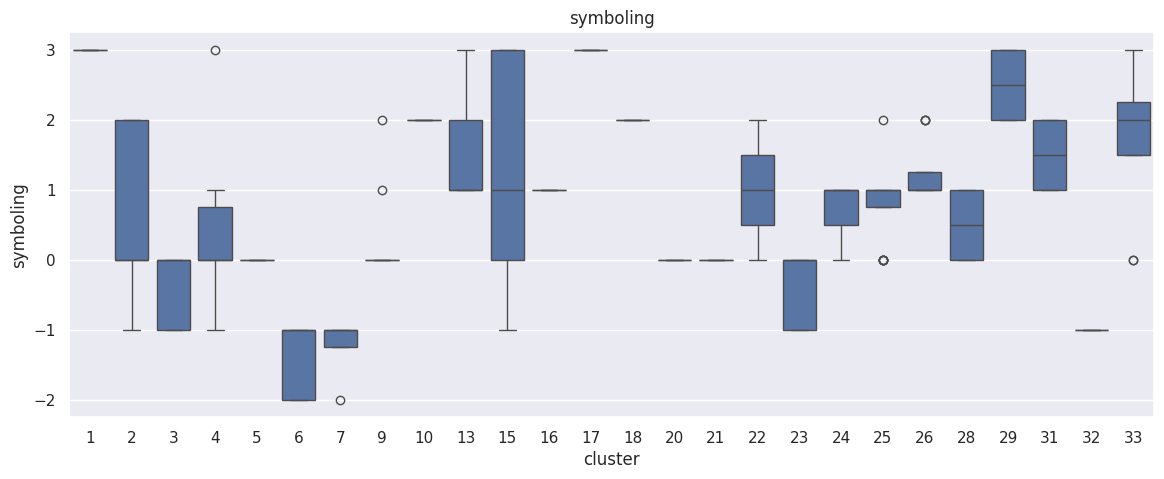

Brand or manufacturer of the car


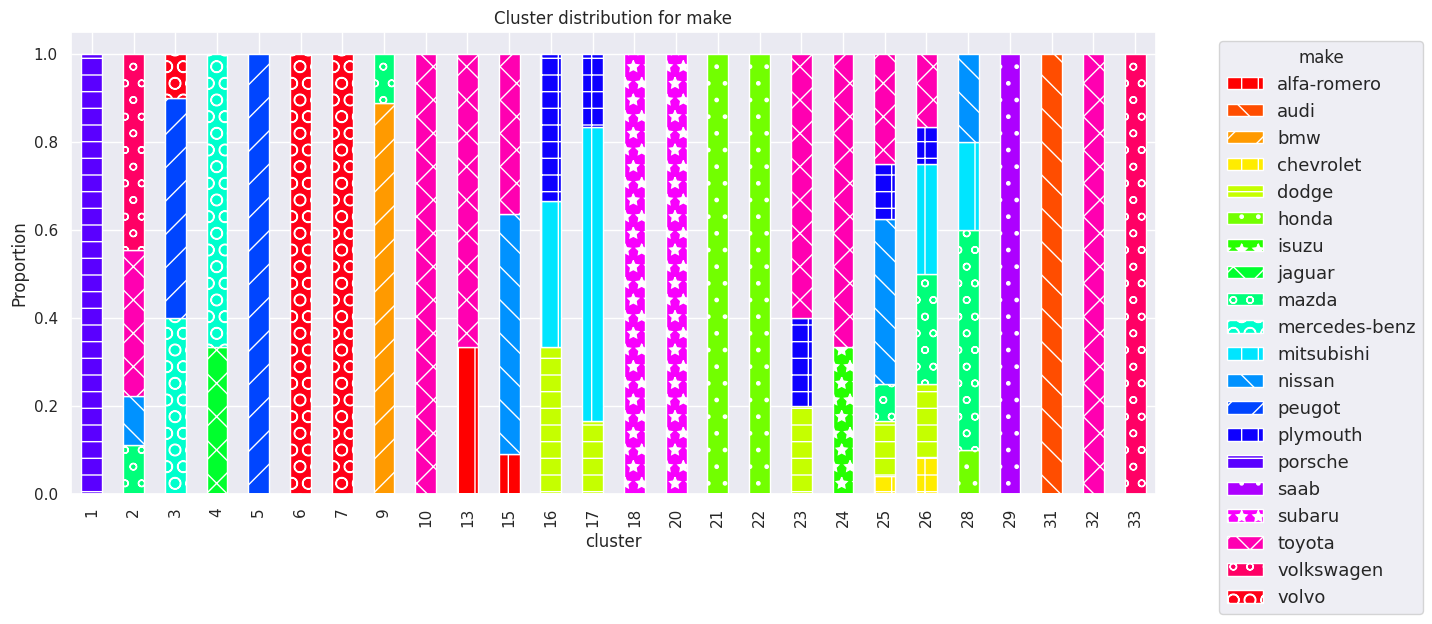

Type of fuel the car uses, such as diesel or gasoline


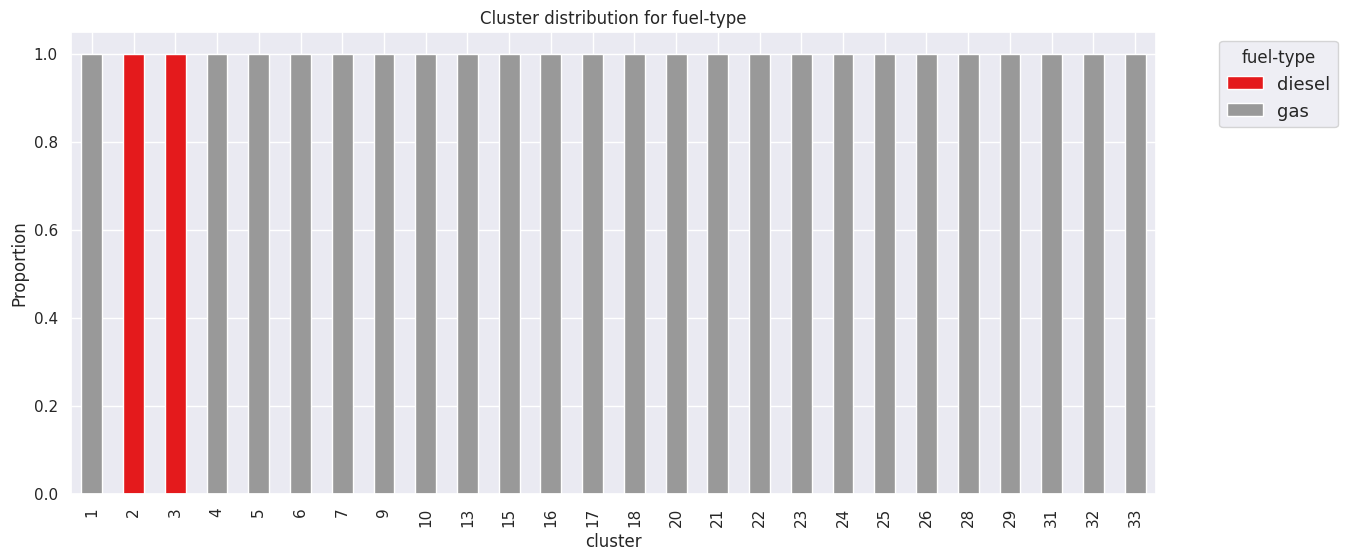

Method of air intake for the engine, either standard or turbocharged


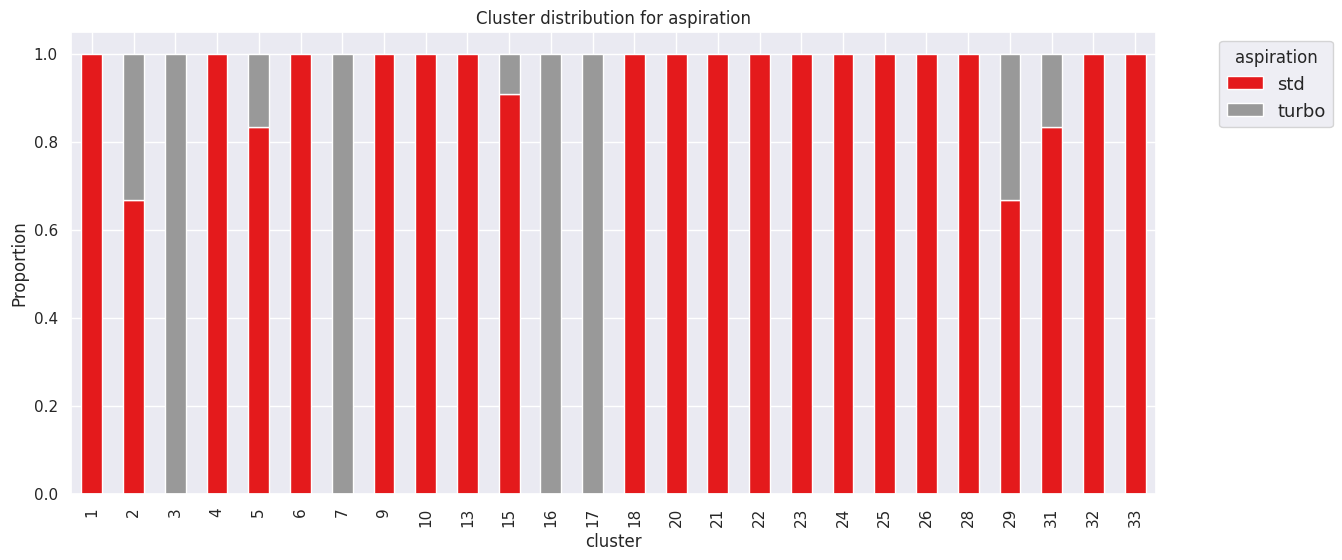

Number of doors the car has


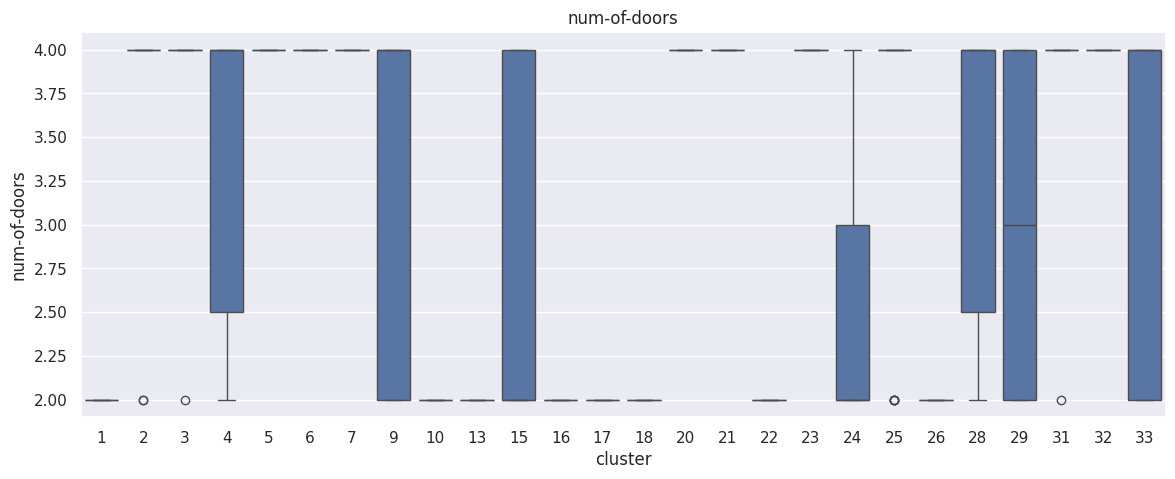

Design form of the car body, like sedan, hatchback, etc.


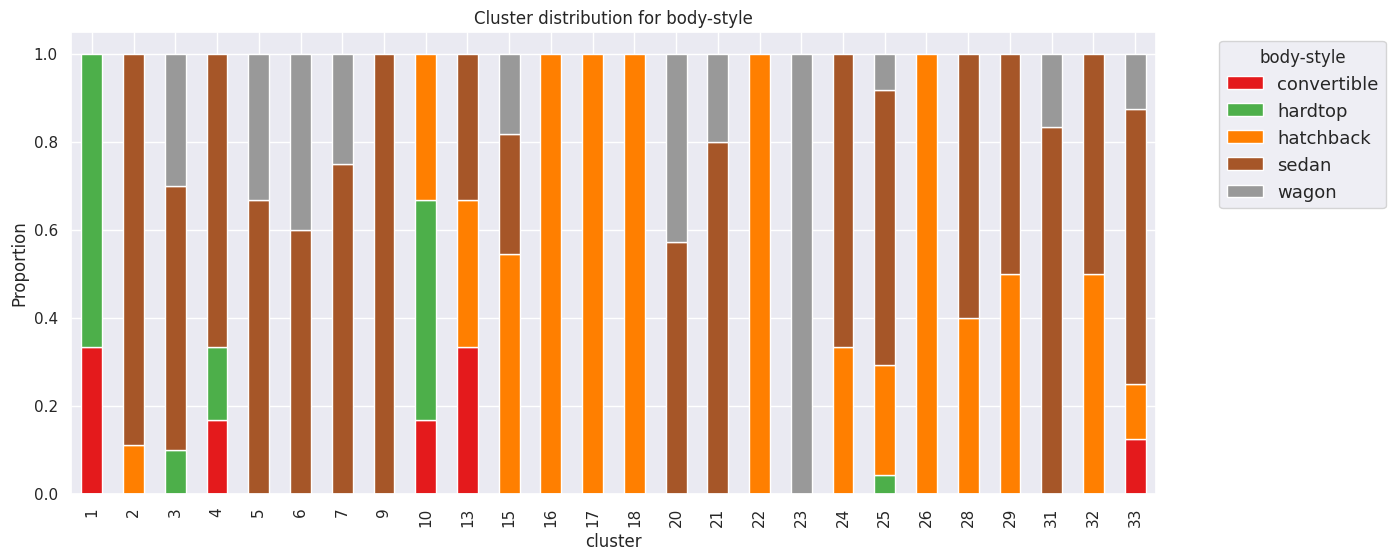

Type of drivetrain, indicating which wheels are powered (front, rear, or all)


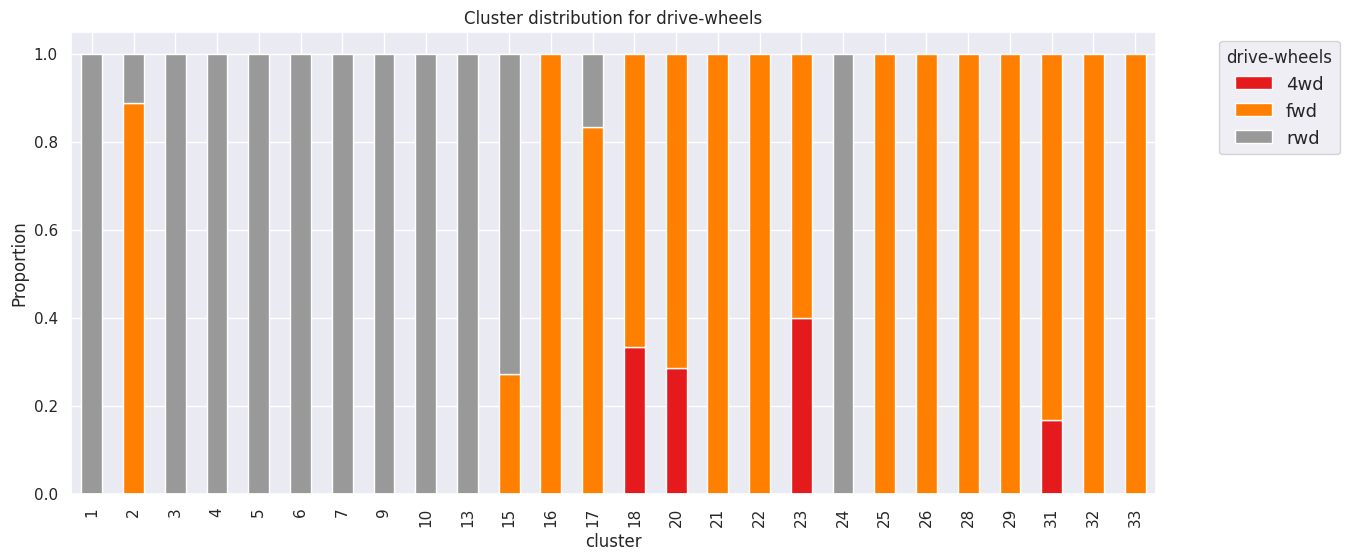

Position of the engine in the car, either front or rear


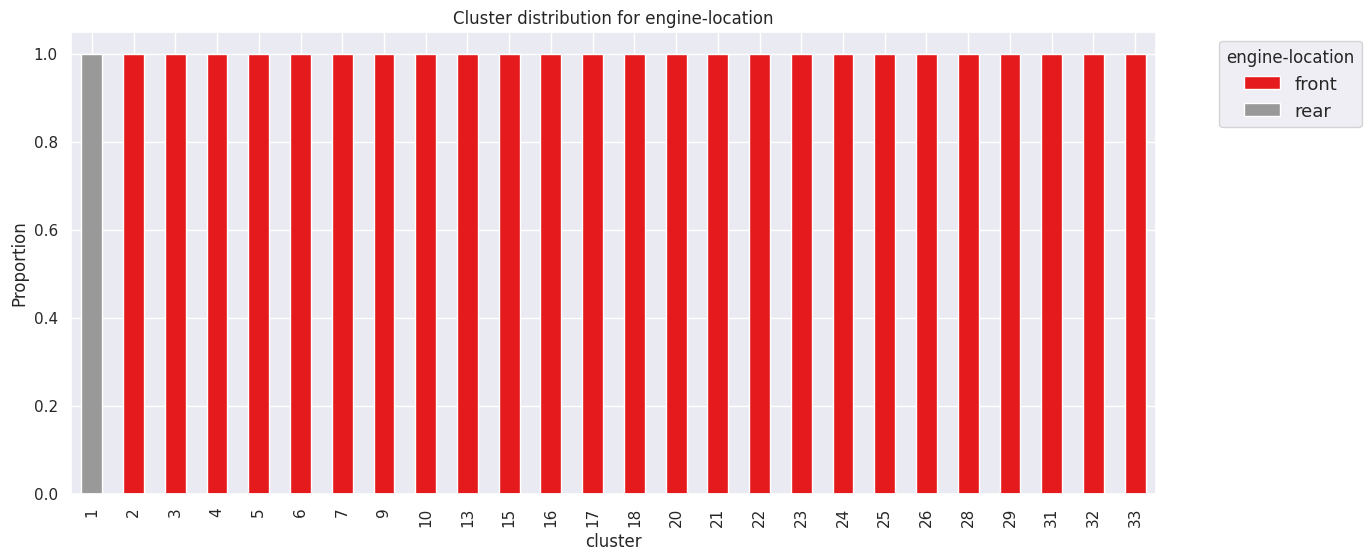

Distance between the front and rear wheels, measured in inches


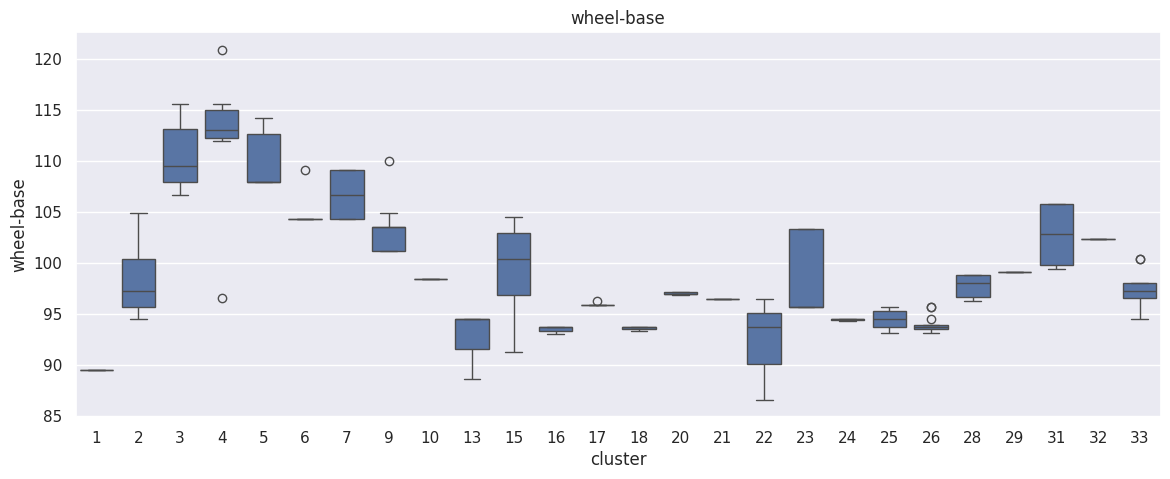

Overall length of the car, measured in inches


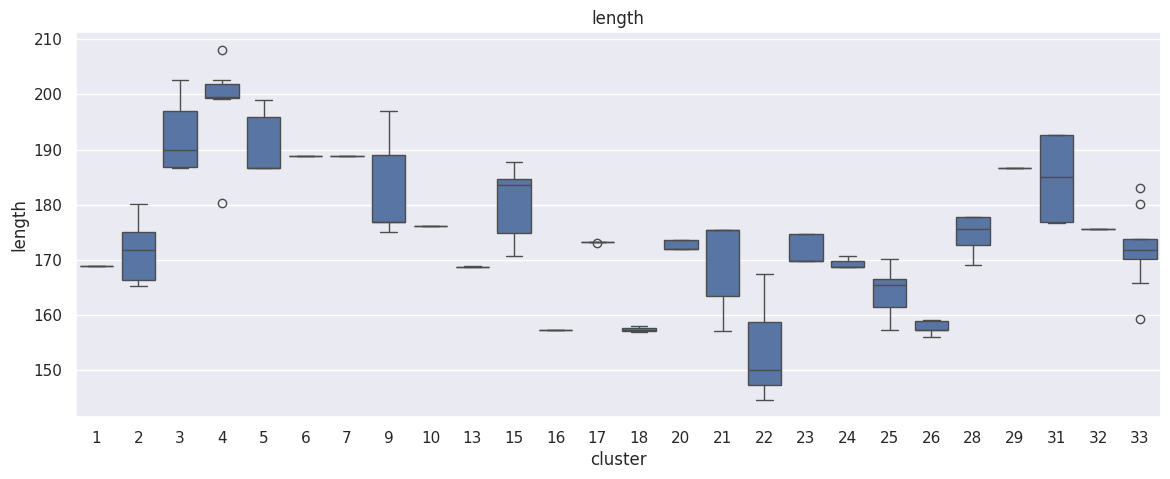

Overall width of the car, measured in inches


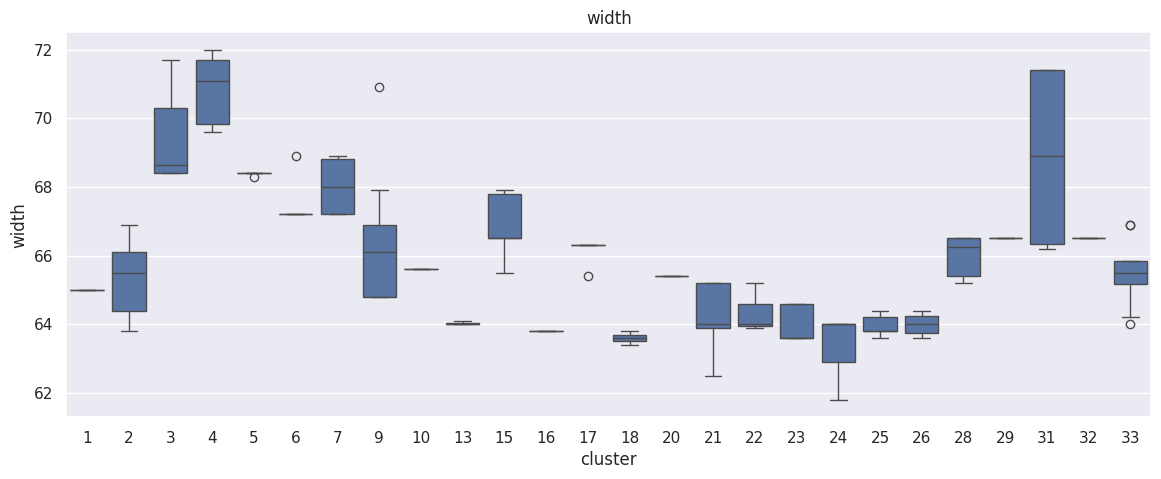

Overall height of the car, measured in inches


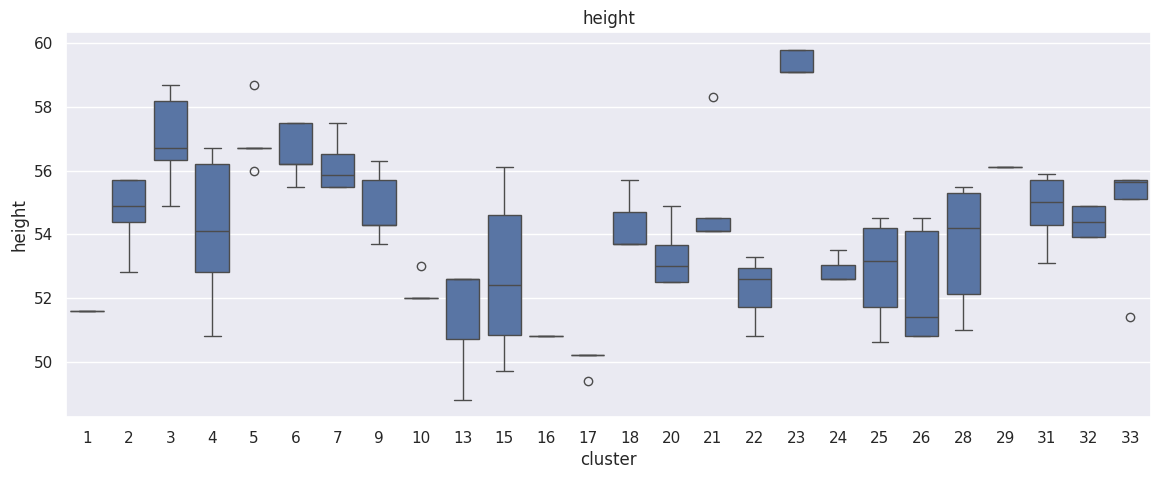

Weight of the car without any passengers or cargo, measured in pounds


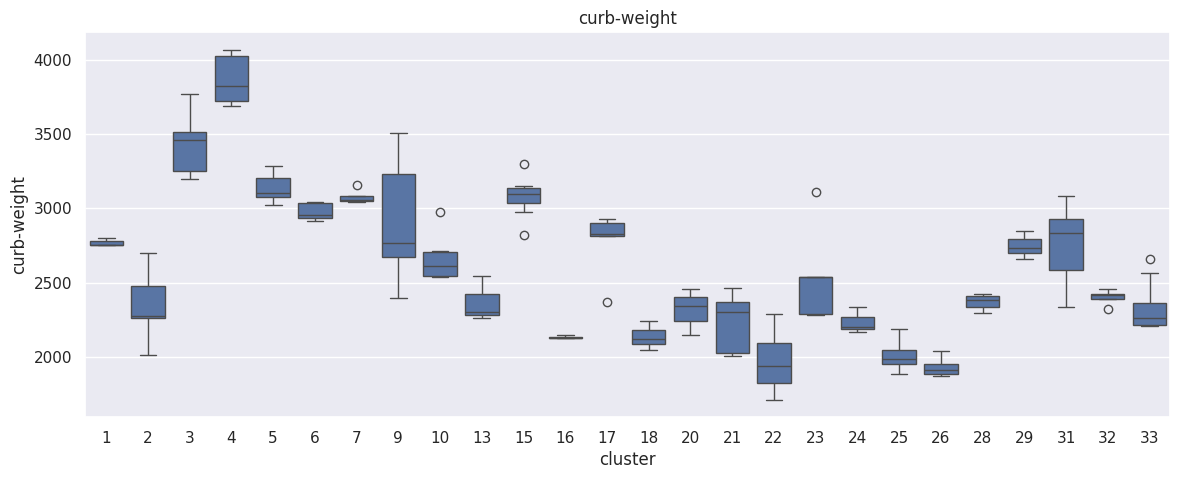

Configuration and design of the engine (e.g., OHC, OHCV)


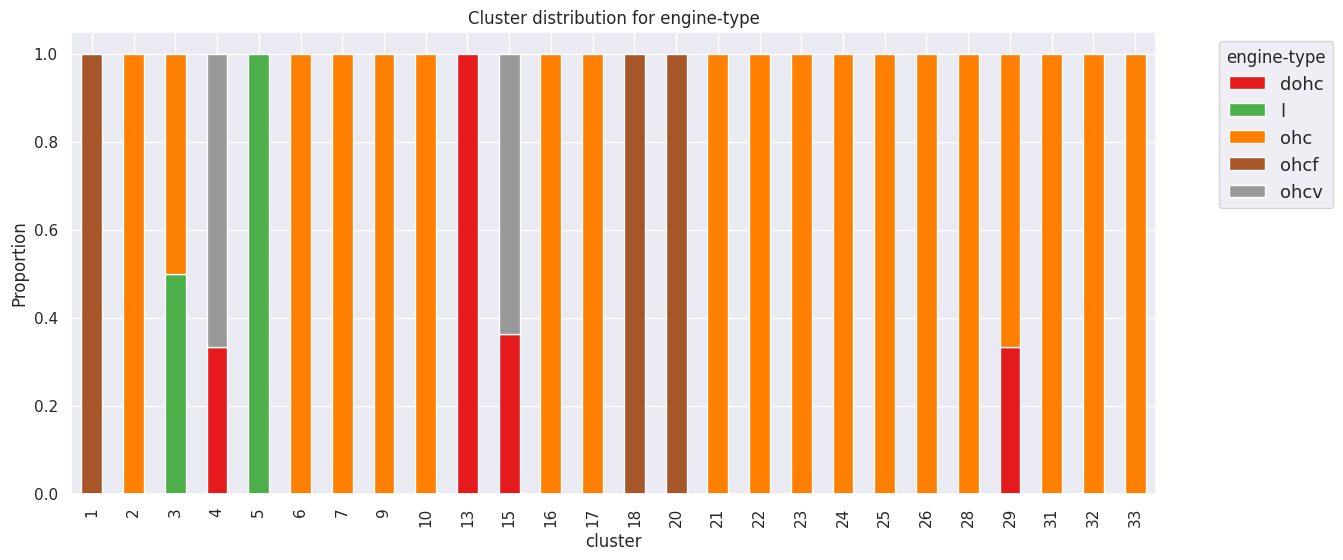

Total number of cylinders in the engine


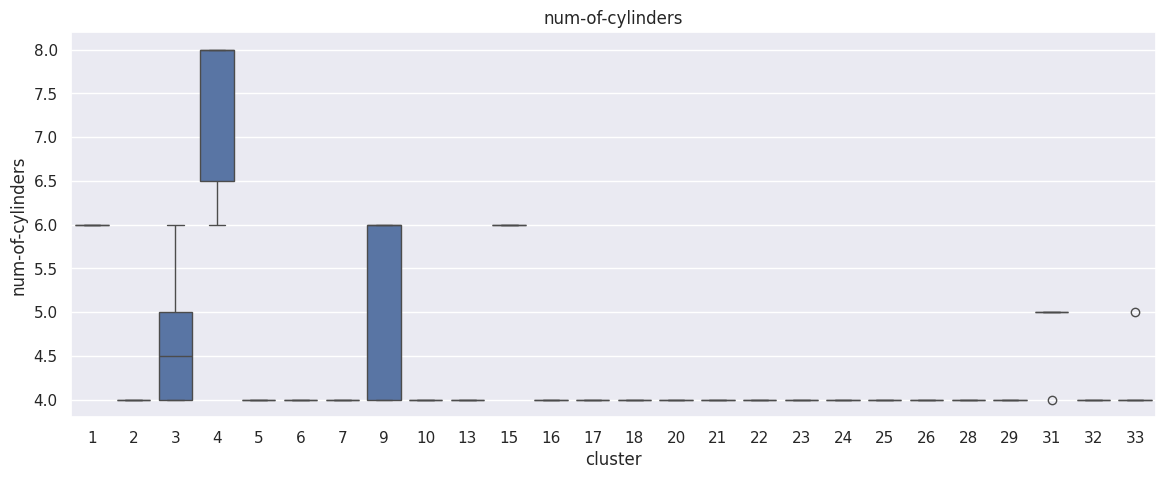

Displacement volume of the engine, measured in cubic centimeters


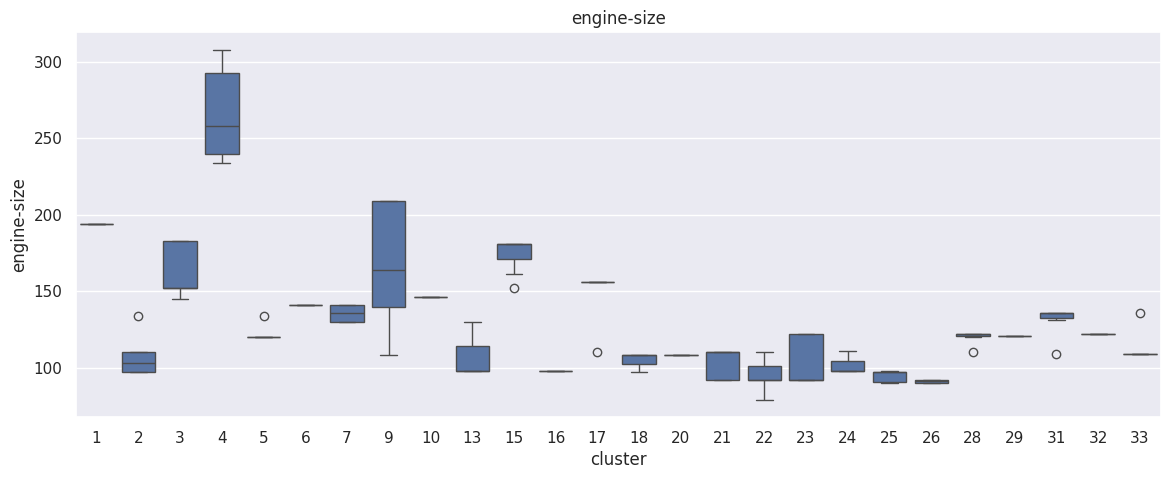

Mechanism or system for delivering fuel to the engine (e.g., MPFI, 2bbl)


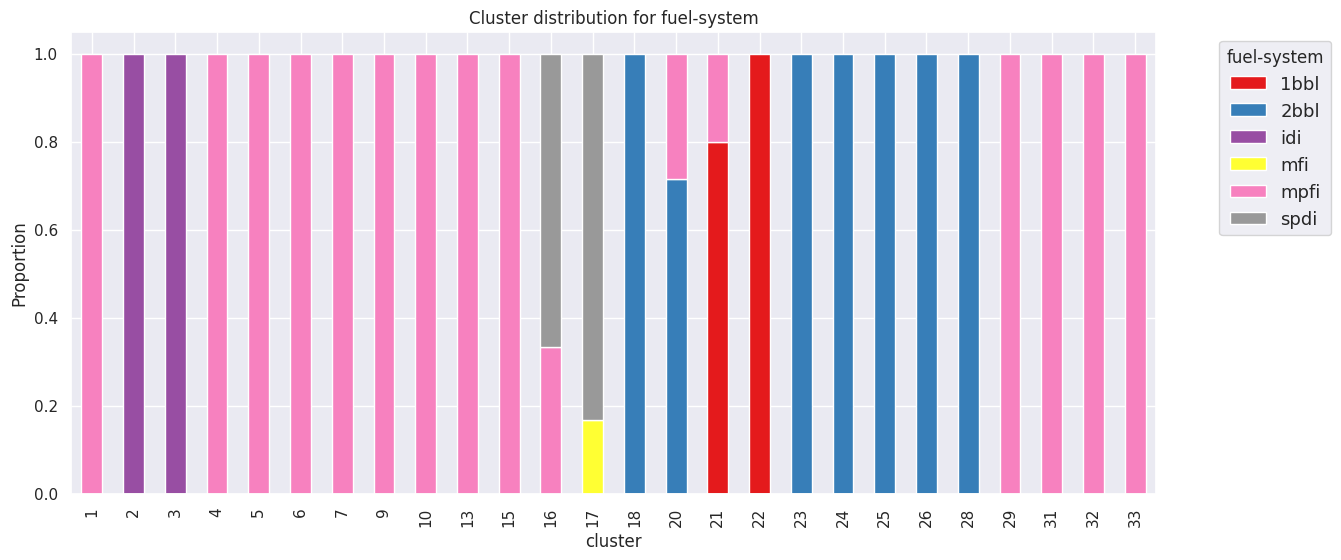

Internal diameter of each cylinder in the engine, measured in inches


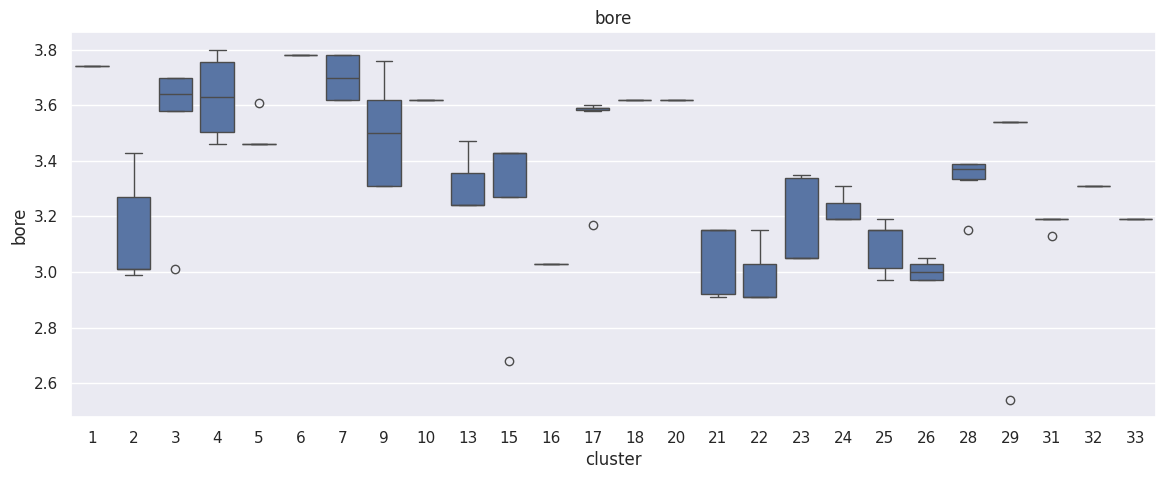

Travel distance of the piston within the engine cylinder, measured in inches


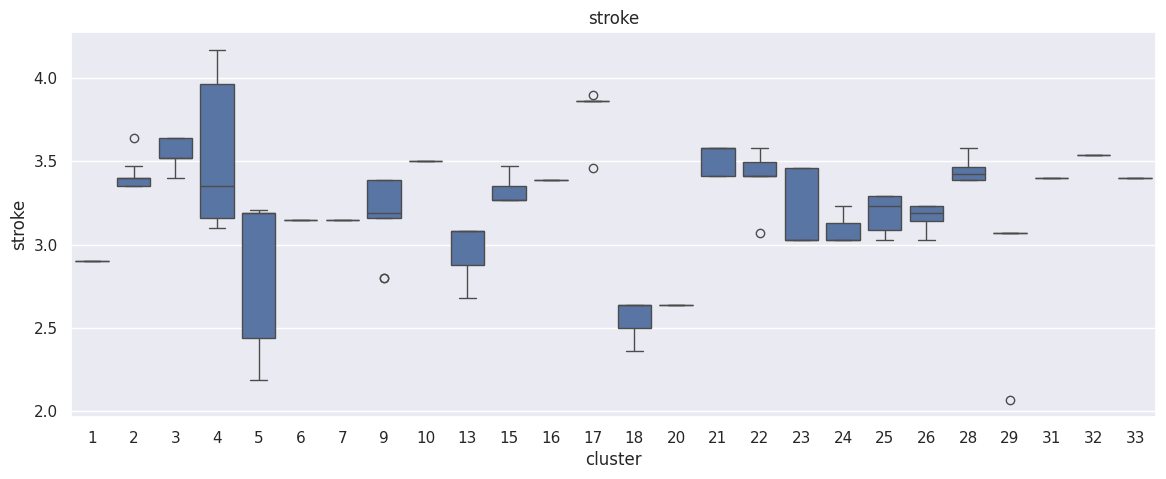

Volume ratio between piston positions at the bottom and top of its stroke


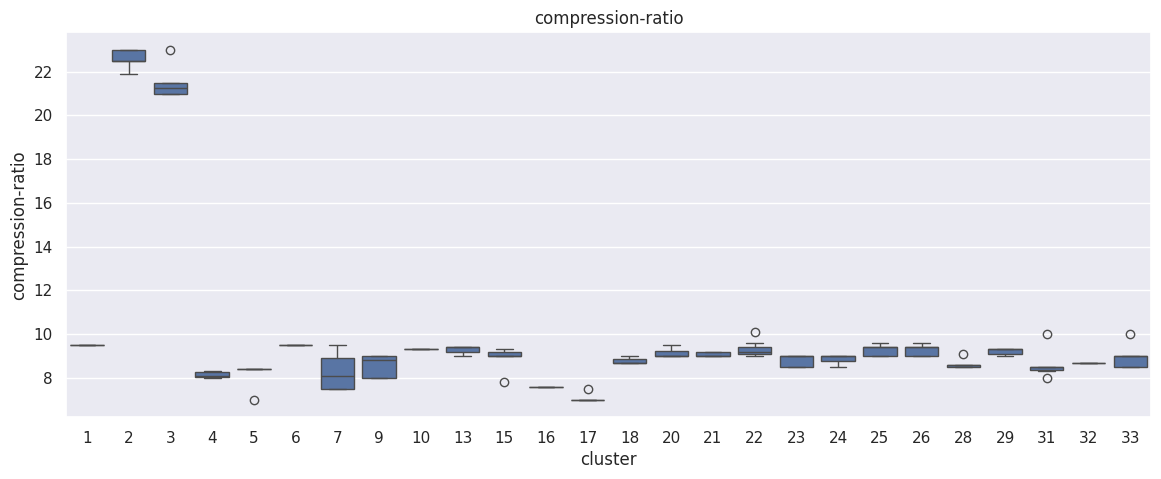

Engine power output, measured in horsepower


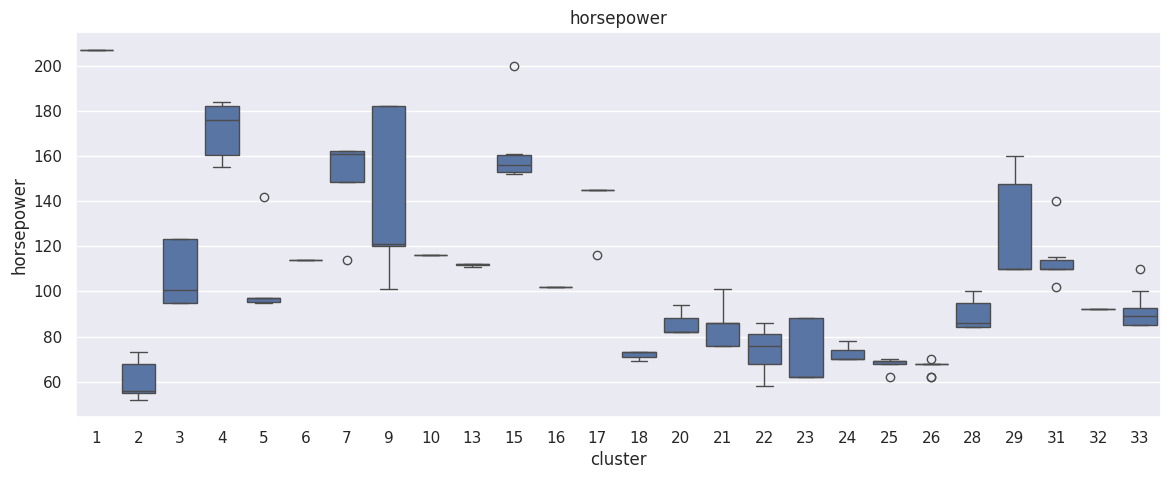

Engine speed at which maximum power output is achieved, measured in RPM


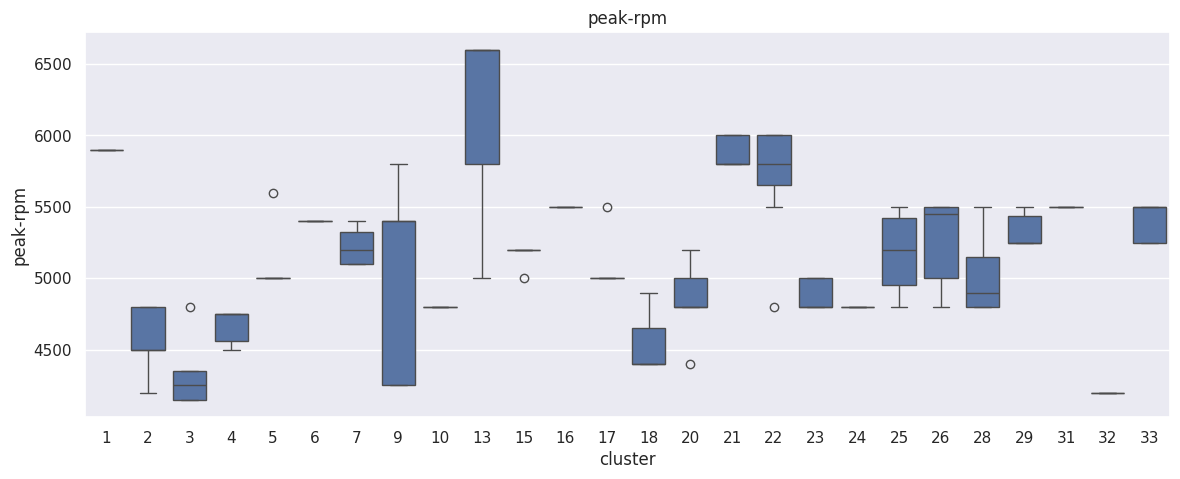

Fuel efficiency during city driving, measured in miles per gallon


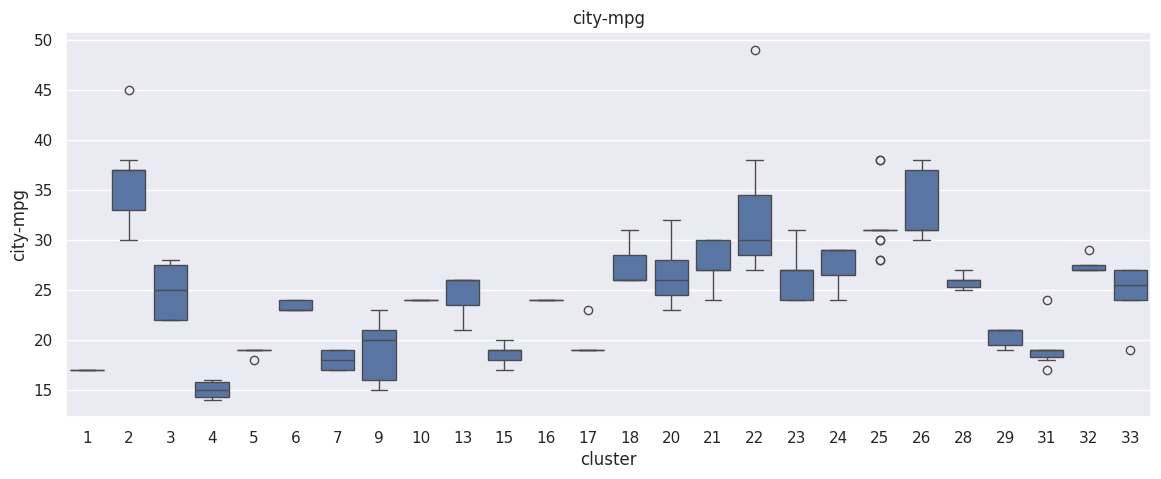

Fuel efficiency during highway driving, measured in miles per gallon


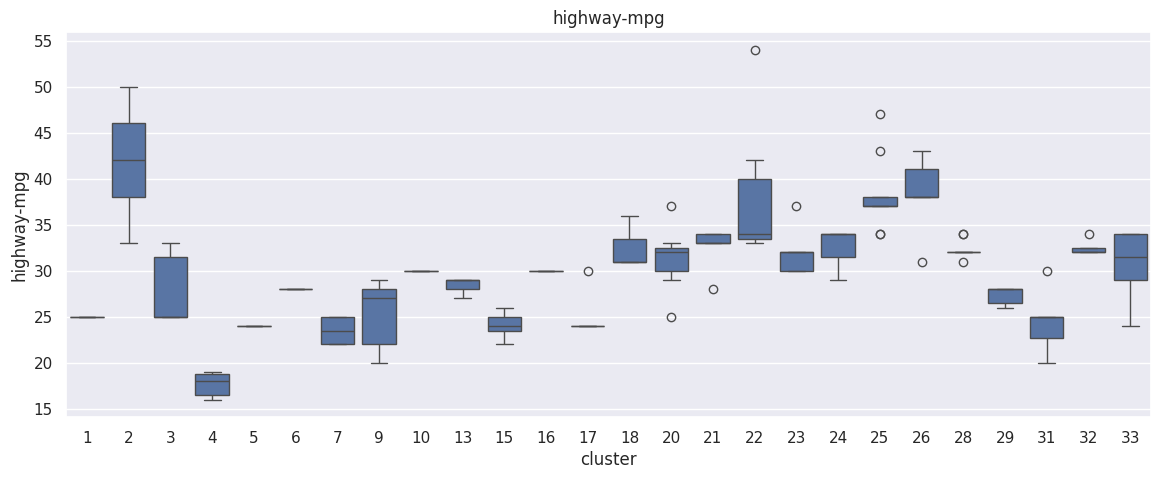

Market price of the car, usually provided in USD


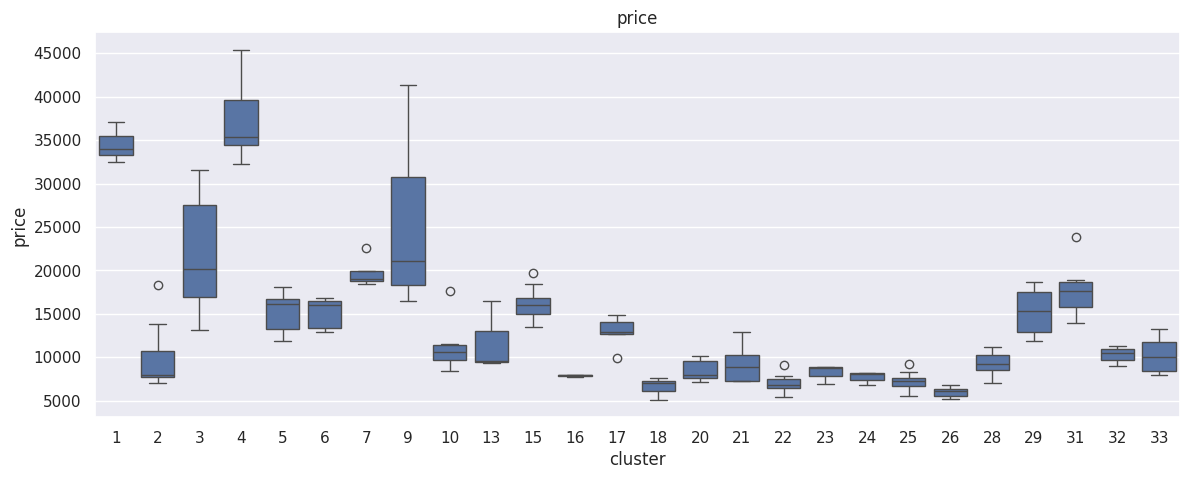

Categorical representation of car price for easier analysis or visualization


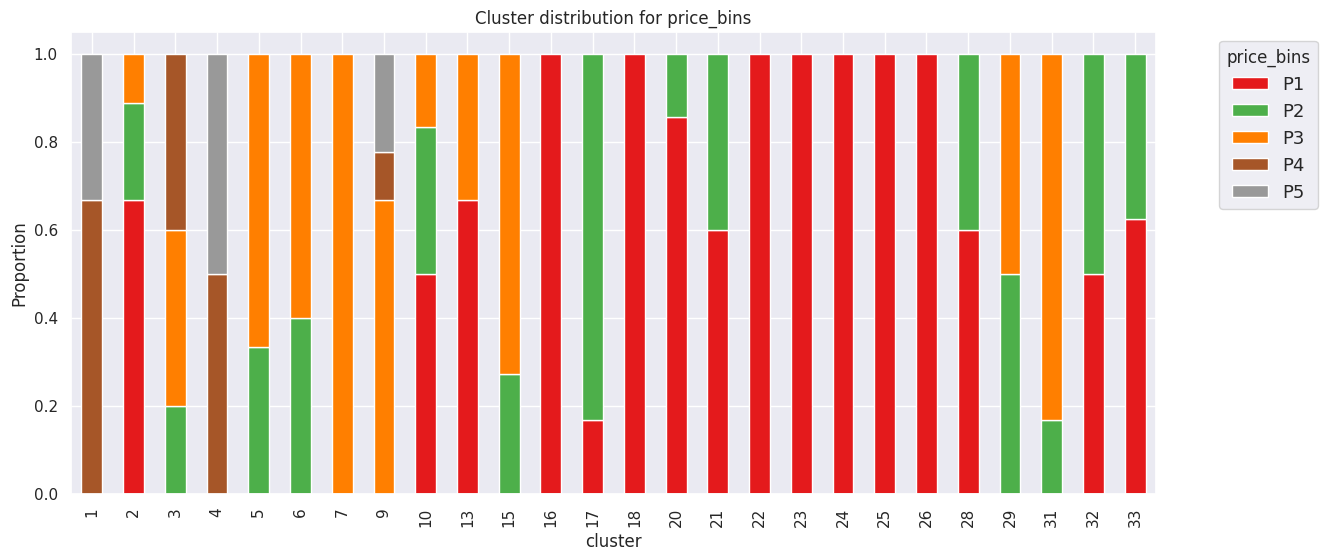

In [ ]:
car_sec_info = car_sec_info[car_sec_info['cluster'].isin(keep_clust)]
numeric_col_names = car_sec_info.select_dtypes(include=[np.number]).columns.tolist()


# Plot cluster feature values
for feature in car_sec_info.columns:

    if feature != 'cluster':

        print(CAR_85_COLUMN_DESCRIPTION[feature])

        if feature in numeric_col_names:

            plt.figure(figsize=(14,5))
            sns.boxplot(car_sec_info, x='cluster', y=feature)
            plt.title(feature)
            plt.show()

        else:


            proportions = car_sec_info.groupby(
                'cluster'
            )[feature].value_counts(
                normalize=True
            ).unstack()


            if proportions.shape[1] > 15:

                # Create stacked bar plot
                ax = proportions.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='hsv')
                plt.title(f'Cluster distribution for {feature}')
                plt.ylabel('Proportion')

                # Define hatch patterns
                patterns = ["|" , "\\" , "/" , "+" , "-", ".", "*","x", "o", "O" ]

                # Apply hatch patterns
                for i, bar_container in enumerate(ax.containers):
                    hatch = patterns[i % len(patterns)]  # Cycle through patterns
                    for bar in bar_container:
                        bar.set_hatch(hatch)

            else:

                # Create stacked bar plot
                ax = proportions.plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Set1')
                plt.title(f'Cluster distribution for {feature}')
                plt.ylabel('Proportion')


            # Add legend
            plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)

            # Get category labels
            category_labels = proportions.columns.tolist()[::-1]
            plt.show()